### Importing Packages 

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib
import mne

import numpy as np                                      
import matplotlib.pyplot as plt                         
import matplotlib.patches as patches
import scipy.signal as signal
from scipy.signal import butter, sosfiltfilt, sosfreqz  
from scipy.io import loadmat
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from pathlib import Path

%matplotlib inline

### Goal:

For each data set specific goals are given in the respective description. Technically speaking, each data set consists of **single-trials of spontaneous EEG activity, one part labeled (training data) and another part unlabeled (test data), and a performance measure.**

The goal is to infer labels for the test set from training data that maximize the performance measure for the true (but to the participant unknown) test labels. 


# Data set ‹self-paced 1s›

Data set provided by Fraunhofer-FIRST, Intelligent Data Analysis Group (Klaus-Robert Müller), and Freie Universität Berlin, Department of Neurology, Neurophysics Group (Gabriel Curio)
Correspondence to Benjamin Blankertz <benjamin.blankertz@tu-berlin.de>

This dataset was recorded from a normal subject during a no-feedback session. The subject sat in a normal chair, relaxed arms resting on the table, fingers in the standard typing position at the computer keyboard. The task was to press with the index and little fingers the corresponding keys in a self-chosen order and timing 'self-paced key typing'. The experiment consisted of 3 sessions of 6 minutes each. All sessions were conducted on the same day with some minutes break inbetween. Typing was done at an average speed of 1 key per second.

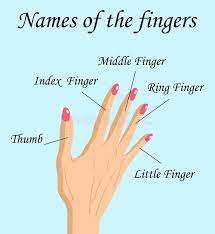

**Format of the data**

- Given are 416 epochs of 500 ms length each ending 130 ms before a keypress. 
- 316 epochs are labeled (0 for upcoming left hand movements and 1 for upcoming right hand movements), the remaining 100 epoches are unlabeled for competition purpose.
- Data are provided in the original 1000 Hz sampling and in a version downsampled at 100 Hz (recommended). 

**Files are provided in Matlab format (*.mat) containing variables:**
- clab: electrode labels
- x_train: training trials (time x channels x trials)
- y_train: corresponding labels (0: left, 1: right), 
- x_test: test trials (time x channels x trials)

**Zipped ASC II format (*.txt.zip).**
- Each of those files contains a 2-D matrix where each row (line) contains the data of one trial, beginning with all samples of the first channel. Channels are in the following order: (F3, F1, Fz, F2, F4, FC5, FC3, FC1, FCz, FC2, FC4, FC6, C5, C3, C1, Cz, C2, C4, C6, CP5, CP3, CP1, CPz, CP2, CP4, CP6, O1, O2).
- In the files containing training data the first entry in each row indicates the class (0: left, 1: right). 
- In the 1000 Hz version trials consist of 500 samples per channel and in the 100 Hz version they consist of 50 samples.

**Requirements and Evaluation** 

Please provide your estimated class labels (0 or 1) for every trial of the test data and give a description of the used algorithm. The performance measure is the classification accuracy (correct classified trials divided by the total number of test trials).

**Technical data**

The recording was made using a NeuroScan amplifier and a Ag/AgCl electrode cap from ECI. 28 EEG channels were measured at positions of the international 10/20-system (F, FC, C, and CP rows and O1, O2). Signals were recorded at 1000 Hz with a band-pass filter between 0.05 and 200 Hz.

**References**
Benjamin Blankertz, Gabriel Curio and Klaus-Robert Müller, Classifying Single Trial EEG: Towards Brain Computer Interfacing, In: T. G. Diettrich and S. Becker and Z. Ghahramani (eds.), Advances in Neural Inf. Proc. Systems 14 (NIPS 01), 2002.

### Loading in Data

In [2]:
# Make sure this juypter notebook is in the same folder as the data, if it isn't create a file path for it

raw1 = scipy.io.loadmat('sp1s_aa.mat')
raw2 = scipy.io.loadmat('sp1s_aa_1000Hz.mat')

**The data is in a dictionary therefore we will need to sort into arrays**, there's probably a faster more efficient way but this is solid for now

In [3]:
#raw1 data which is recorded at 100 Hz
data = list(raw1.items())
an_array = np.array(data, dtype = object)

temp3 = an_array[3]
clab_100 = temp3[1]

temp4 = an_array[4]
x_train_100 = temp4[1]

temp5 = an_array[5]
y_train_100 = temp5[1]

temp6 = an_array[6]
x_test_100 = temp6[1]

#A2, feature extraction, chnage 3-d to 2-d, CSP, 
#pick channels that are valuable, frquency band, 

In [4]:
# Define our filter variables
fs = 240.0                      # Hz; sampling rate
dt = 1000. / fs                 # ms; time between samples
sdt = np.round(dt).astype(int); # rounded dt so that we can index samples
hp = 0.1                        # Hz; our low cut for our bandpass
lp = 30.                        # Hz; our high cut for our bandpass
order = 3                       # filter order (functionally doubled)

# Create our filter coefficient as as a second-order section
# Note: by defining 'fs' we don't divide our windows by the Nyquist
sos = butter(order, [hp, lp], analog = False, btype = 'band', output = 'sos', fs = fs)

In [5]:
# Define ERP-related variables
epoch_start = 0    # ms
epoch_end = 500    # ms

baseline_start = 0 # ms
baseline_end = 100 # ms

erp_start = 200    # ms
erp_end = 400      # ms

# Let's translate these into index space to save time later
e_s = np.round(epoch_start / sdt).astype(int)     # epoch start
e_e = np.round(epoch_end / sdt).astype(int)       # epoch end
bl_s = np.round(baseline_start / sdt).astype(int) # baseline start
bl_e = np.round(baseline_end / sdt).astype(int)   # baseline end
erp_s = np.round(erp_start / sdt).astype(int)     # ERP start
erp_e = np.round(erp_end / sdt).astype(int)       # ERP end

# channels = []

# for j in clab_100:
    
#     for i in j:
#         channels.append(i)
        
# print(channels)
clab_100

array([[array(['F3'], dtype='<U2'), array(['F1'], dtype='<U2'),
        array(['Fz'], dtype='<U2'), array(['F2'], dtype='<U2'),
        array(['F4'], dtype='<U2'), array(['FC5'], dtype='<U3'),
        array(['FC3'], dtype='<U3'), array(['FC1'], dtype='<U3'),
        array(['FCz'], dtype='<U3'), array(['FC2'], dtype='<U3'),
        array(['FC4'], dtype='<U3'), array(['FC6'], dtype='<U3'),
        array(['C5'], dtype='<U2'), array(['C3'], dtype='<U2'),
        array(['C1'], dtype='<U2'), array(['Cz'], dtype='<U2'),
        array(['C2'], dtype='<U2'), array(['C4'], dtype='<U2'),
        array(['C6'], dtype='<U2'), array(['CP5'], dtype='<U3'),
        array(['CP3'], dtype='<U3'), array(['CP1'], dtype='<U3'),
        array(['CPz'], dtype='<U3'), array(['CP2'], dtype='<U3'),
        array(['CP4'], dtype='<U3'), array(['CP6'], dtype='<U3'),
        array(['O1'], dtype='<U2'), array(['O2'], dtype='<U2')]],
      dtype=object)

In [11]:
clab_channels = clab_100[0]

channels = []

for j in clab_channels:
    
    for i in j:
        channels.append(i)
        
print(channels)

['F3', 'F1', 'Fz', 'F2', 'F4', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'O1', 'O2']


We have 157 target trials
We have 159 non-target trials
['F3', 'F1', 'Fz', 'F2', 'F4', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'O1', 'O2']


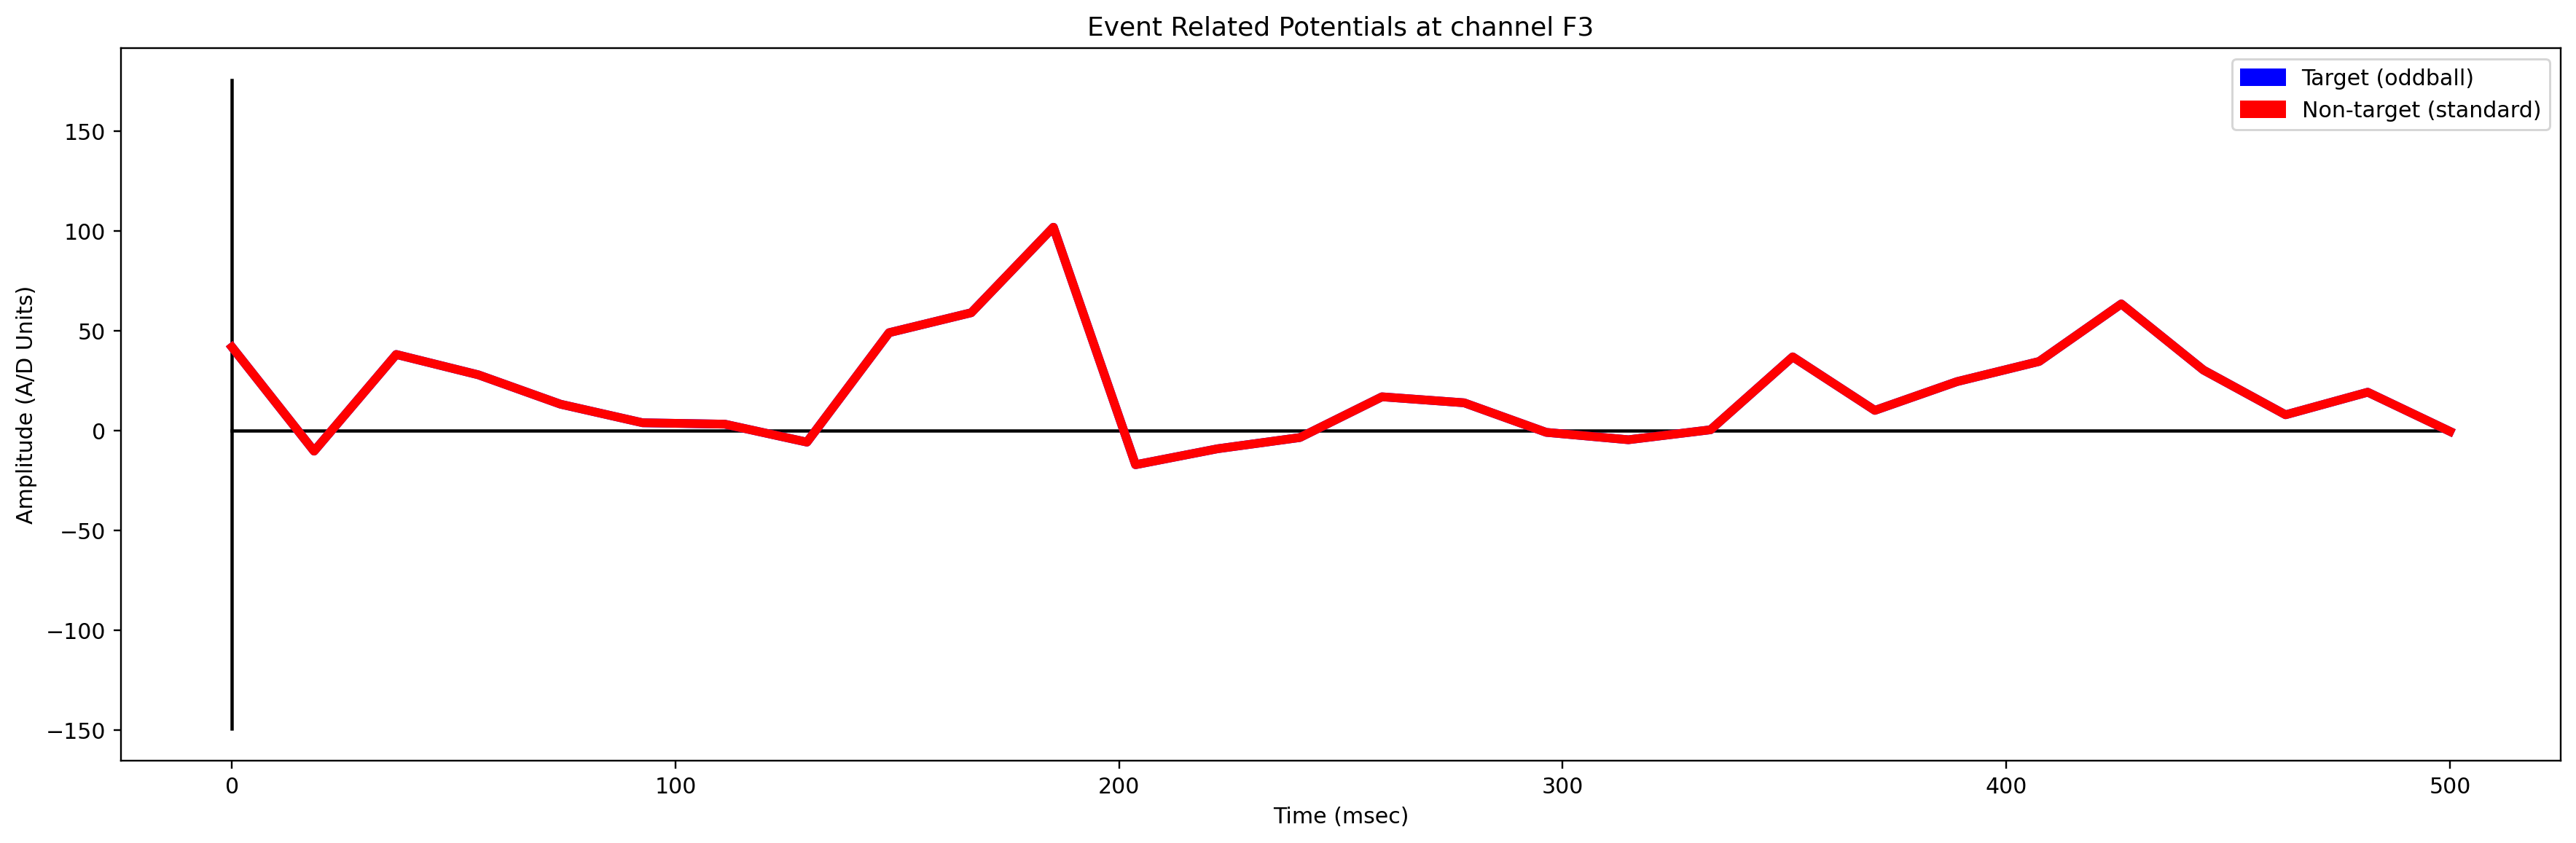

In [12]:
# Seperate target and non-target for plotting
tar     = x_train_100[np.where(y_train_100 == 1)[0], :, :]
non_tar = x_train_100[np.where(y_train_100 == 0)[0], :, :]

print('We have %d target trials' % tar.shape[0])
print('We have %d non-target trials' % non_tar.shape[0])

# We'll take the average of all trials to create an averaged ERP
tar_avg     = np.mean(tar, 0)
non_tar_avg = np.mean(non_tar, 0)

# Define channel of interest and create an array of time points
chan = channels[0] # let's plot Pz
ch = np.where(clab_100 == chan)[1][0]
times = np.linspace(epoch_start, epoch_end, x_train_100.shape[1])

# Initialize plot and calculate min and max y value
fig, ax = matplotlib.pyplot.subplots(nrows=1, ncols=1, figsize=(20, 6))
min_y = min(np.min(tar_avg), np.min(non_tar_avg))
max_y = max(np.max(tar_avg), np.max(non_tar_avg))

print(channels)

# Plot x and y axes
matplotlib.pyplot.plot([np.min(times), np.max(times)], [0, 0], color='k');  # x-axis
matplotlib.pyplot.plot([0, 0], [min_y, max_y], color='k');                  # y-axis

# Plot our averaged ERPs
matplotlib.pyplot.plot(times, tar_avg[:, ch], 'b', linewidth=4)
matplotlib.pyplot.plot(times, non_tar_avg[:, ch], 'r', linewidth=4)

# Highlight the baseline window and window of interest of our ERP
# baseline = matplotlib.patches.Rectangle([baseline_start, min_y], baseline_end, np.abs(min_y)+max_y, 
#                              color='cyan', alpha=0.2)
# erp_win = matplotlib.patches.Rectangle([erp_start, min_y], erp_end-erp_start, np.abs(min_y)+max_y, 
#                              color='lime', alpha=0.3)

# # Add our baseline and window of interest highlights
# ax.add_patch(baseline)
# ax.add_patch(erp_win)

# Manually create legends since patches will corrupt default handles
legend_ = [matplotlib.patches.Patch(color='b', label = 'Target (oddball)'),
           matplotlib.patches.Patch(color='r', label = 'Non-target (standard)')]

# Finalize plot and set a high DPI for a crisp, hi-res figure
matplotlib.pyplot.xlabel('Time (msec)');
matplotlib.pyplot.ylabel('Amplitude (A/D Units)');
matplotlib.pyplot.legend(handles=legend_, loc="upper right");
matplotlib.pyplot.title('Event Related Potentials at channel %s' % chan);
fig.set_dpi(216);
matplotlib.pyplot.show();

In [13]:
 x_train_100.shape[2]

316

In [14]:
tar[0] == non_tar[0]

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

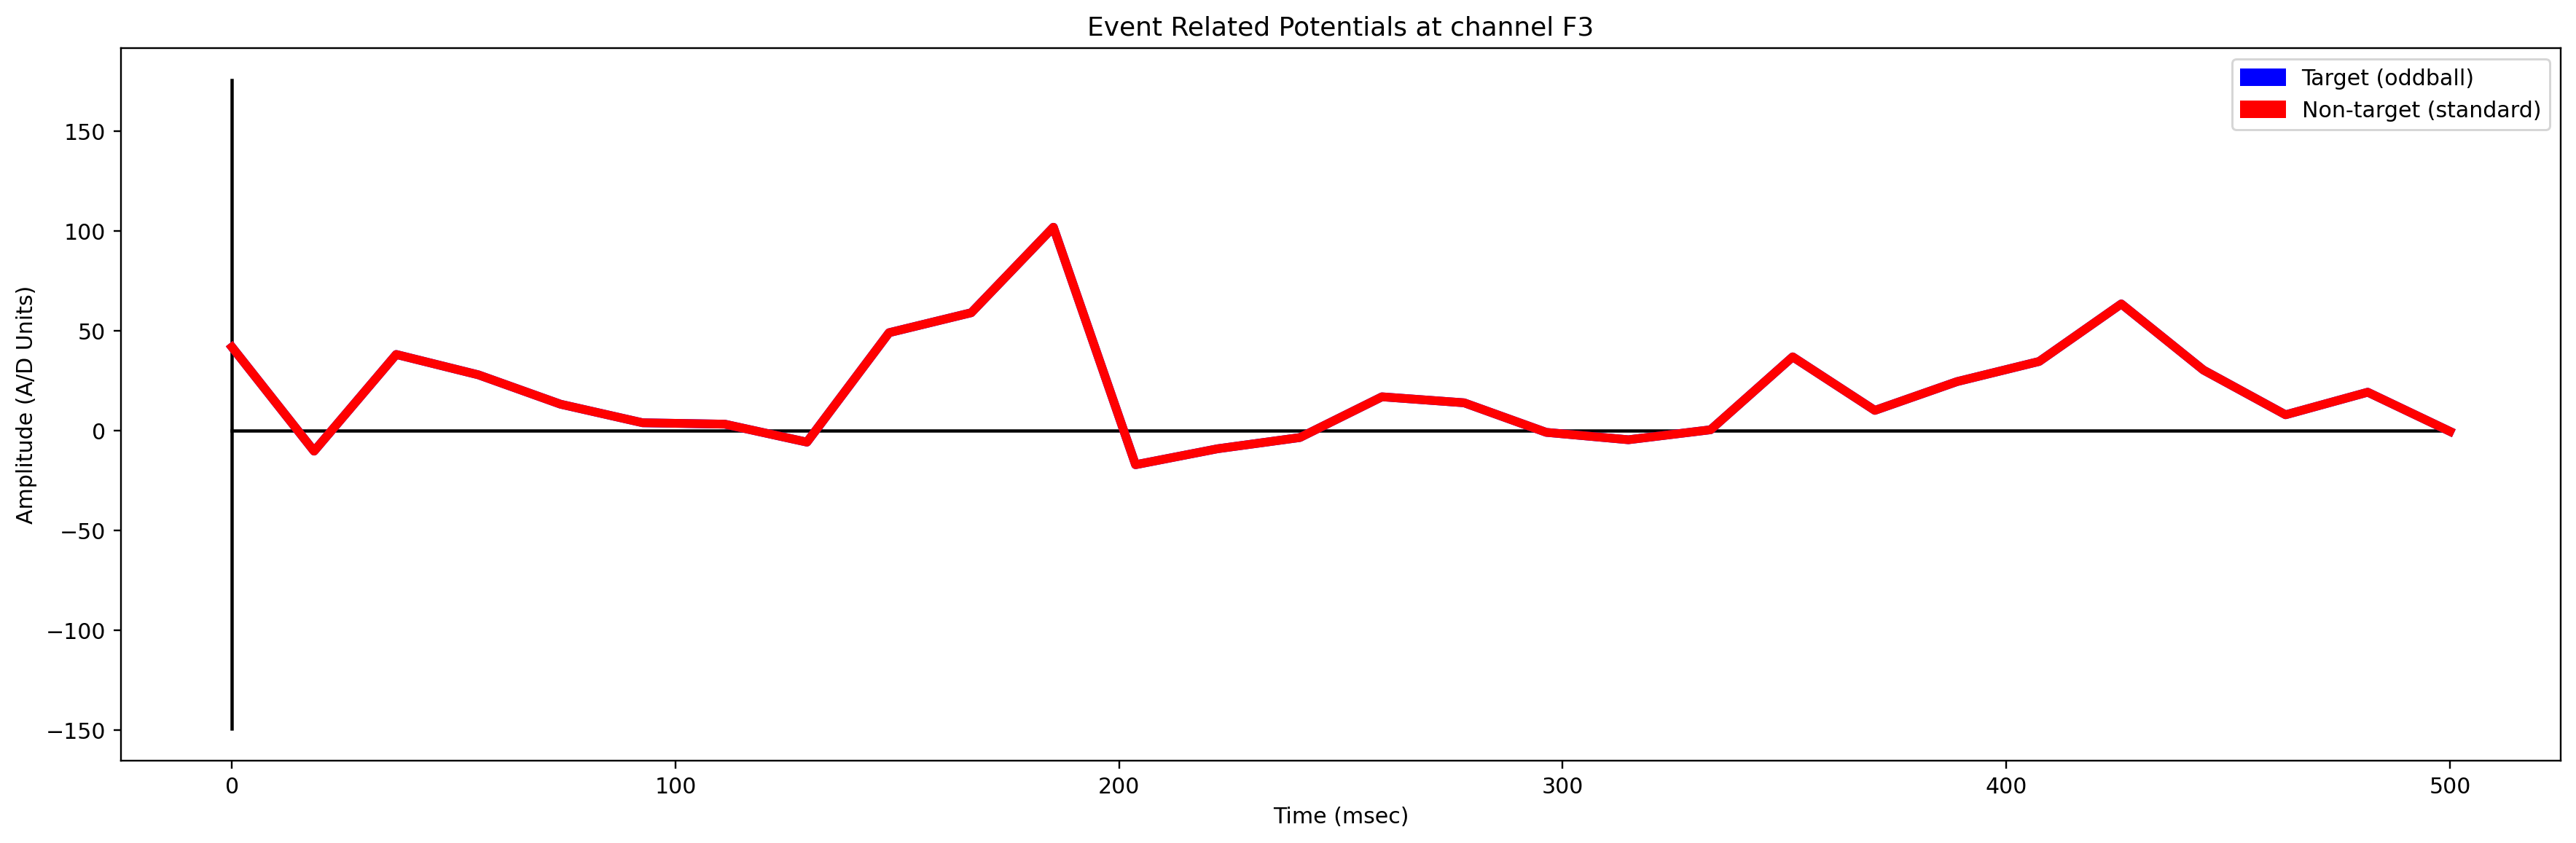

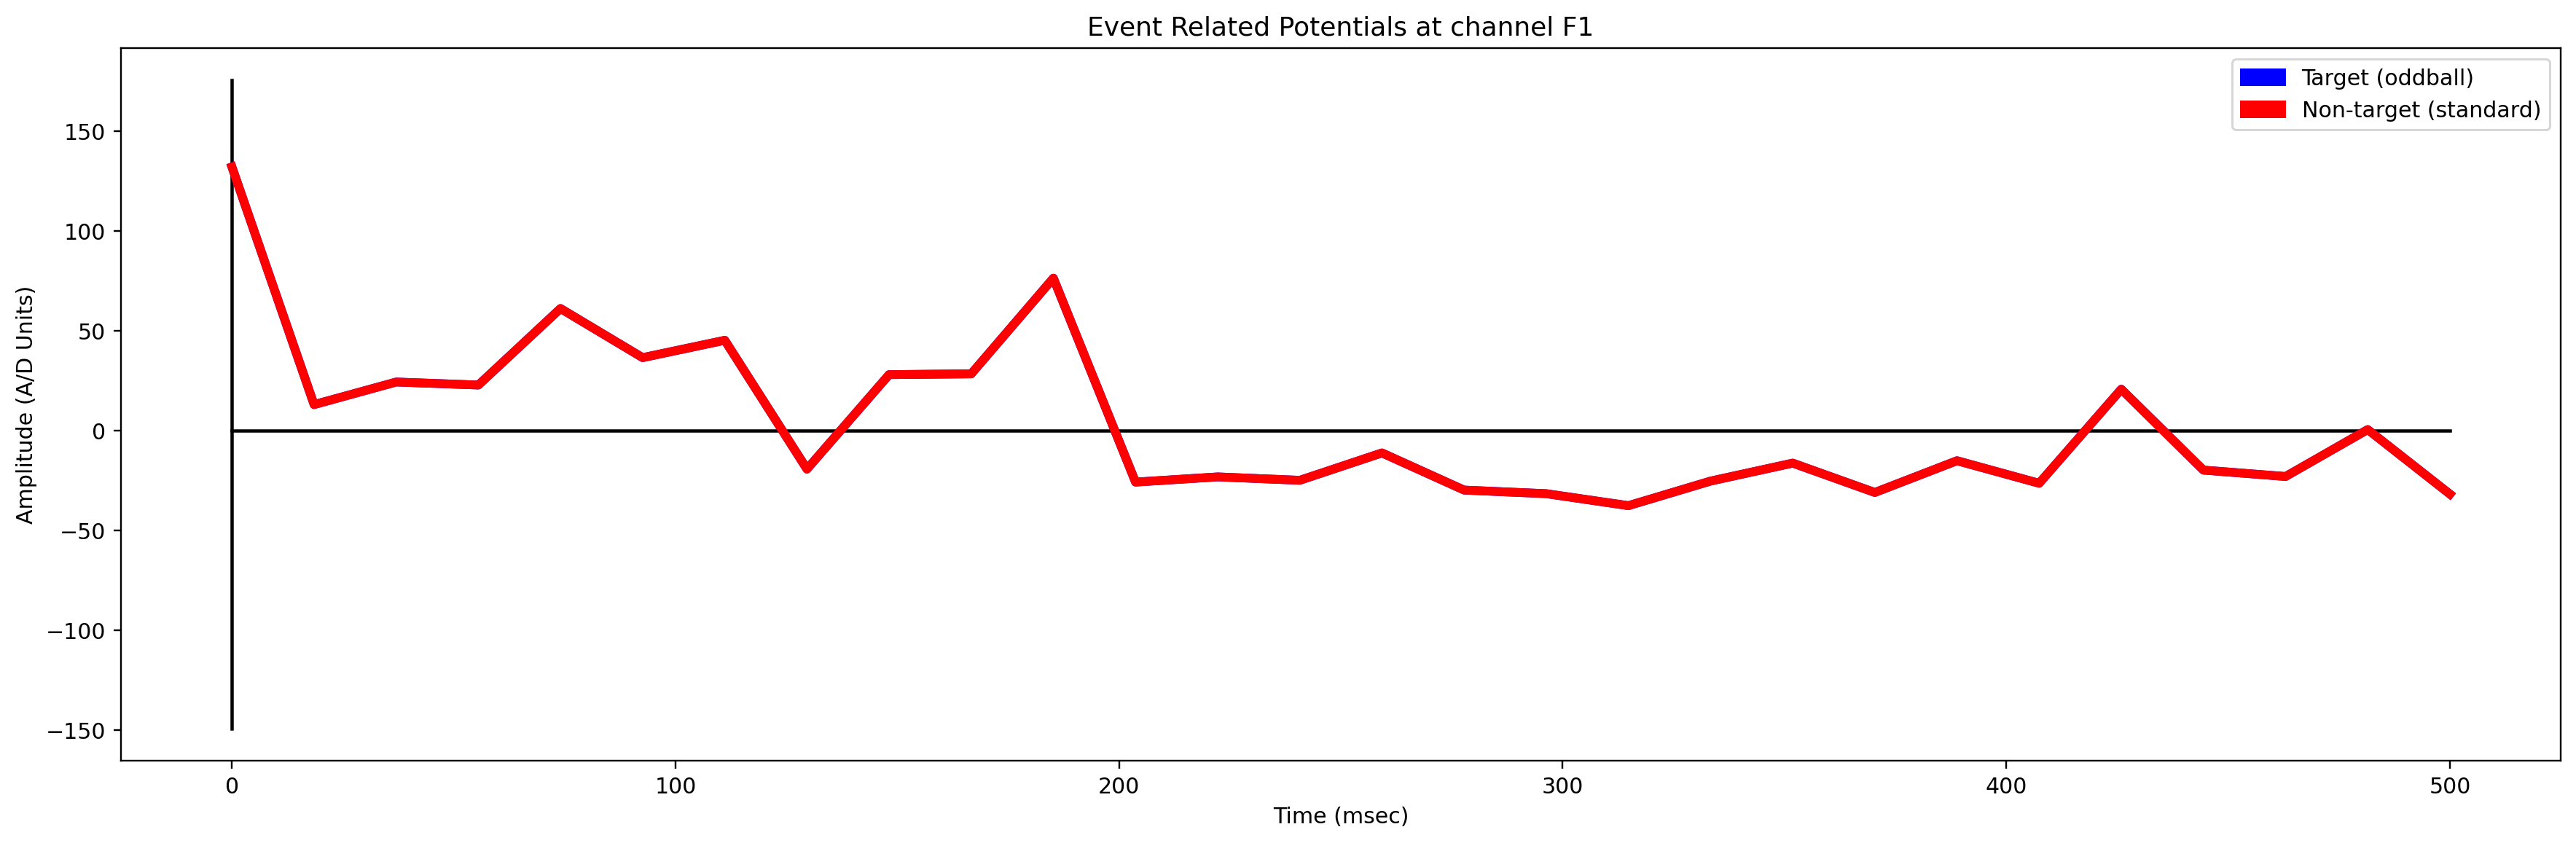

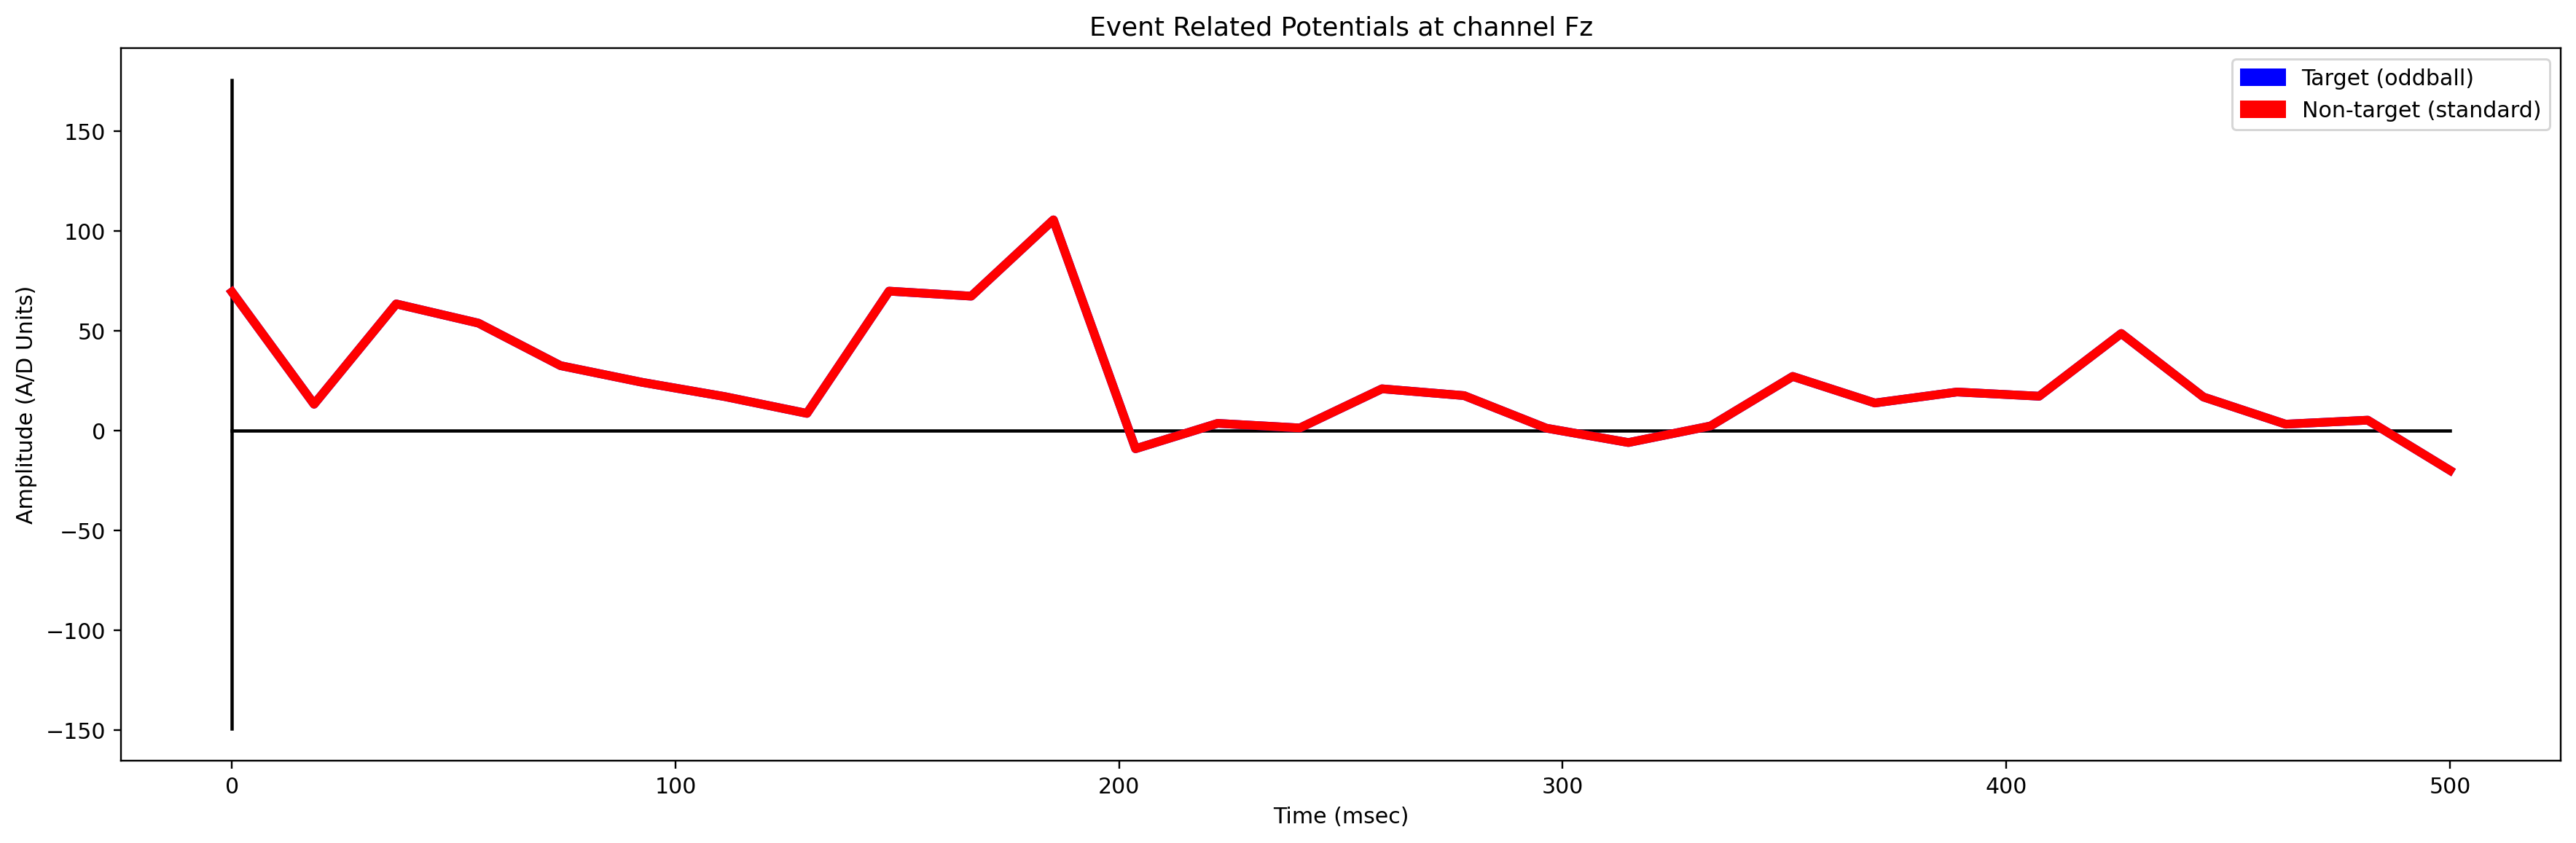

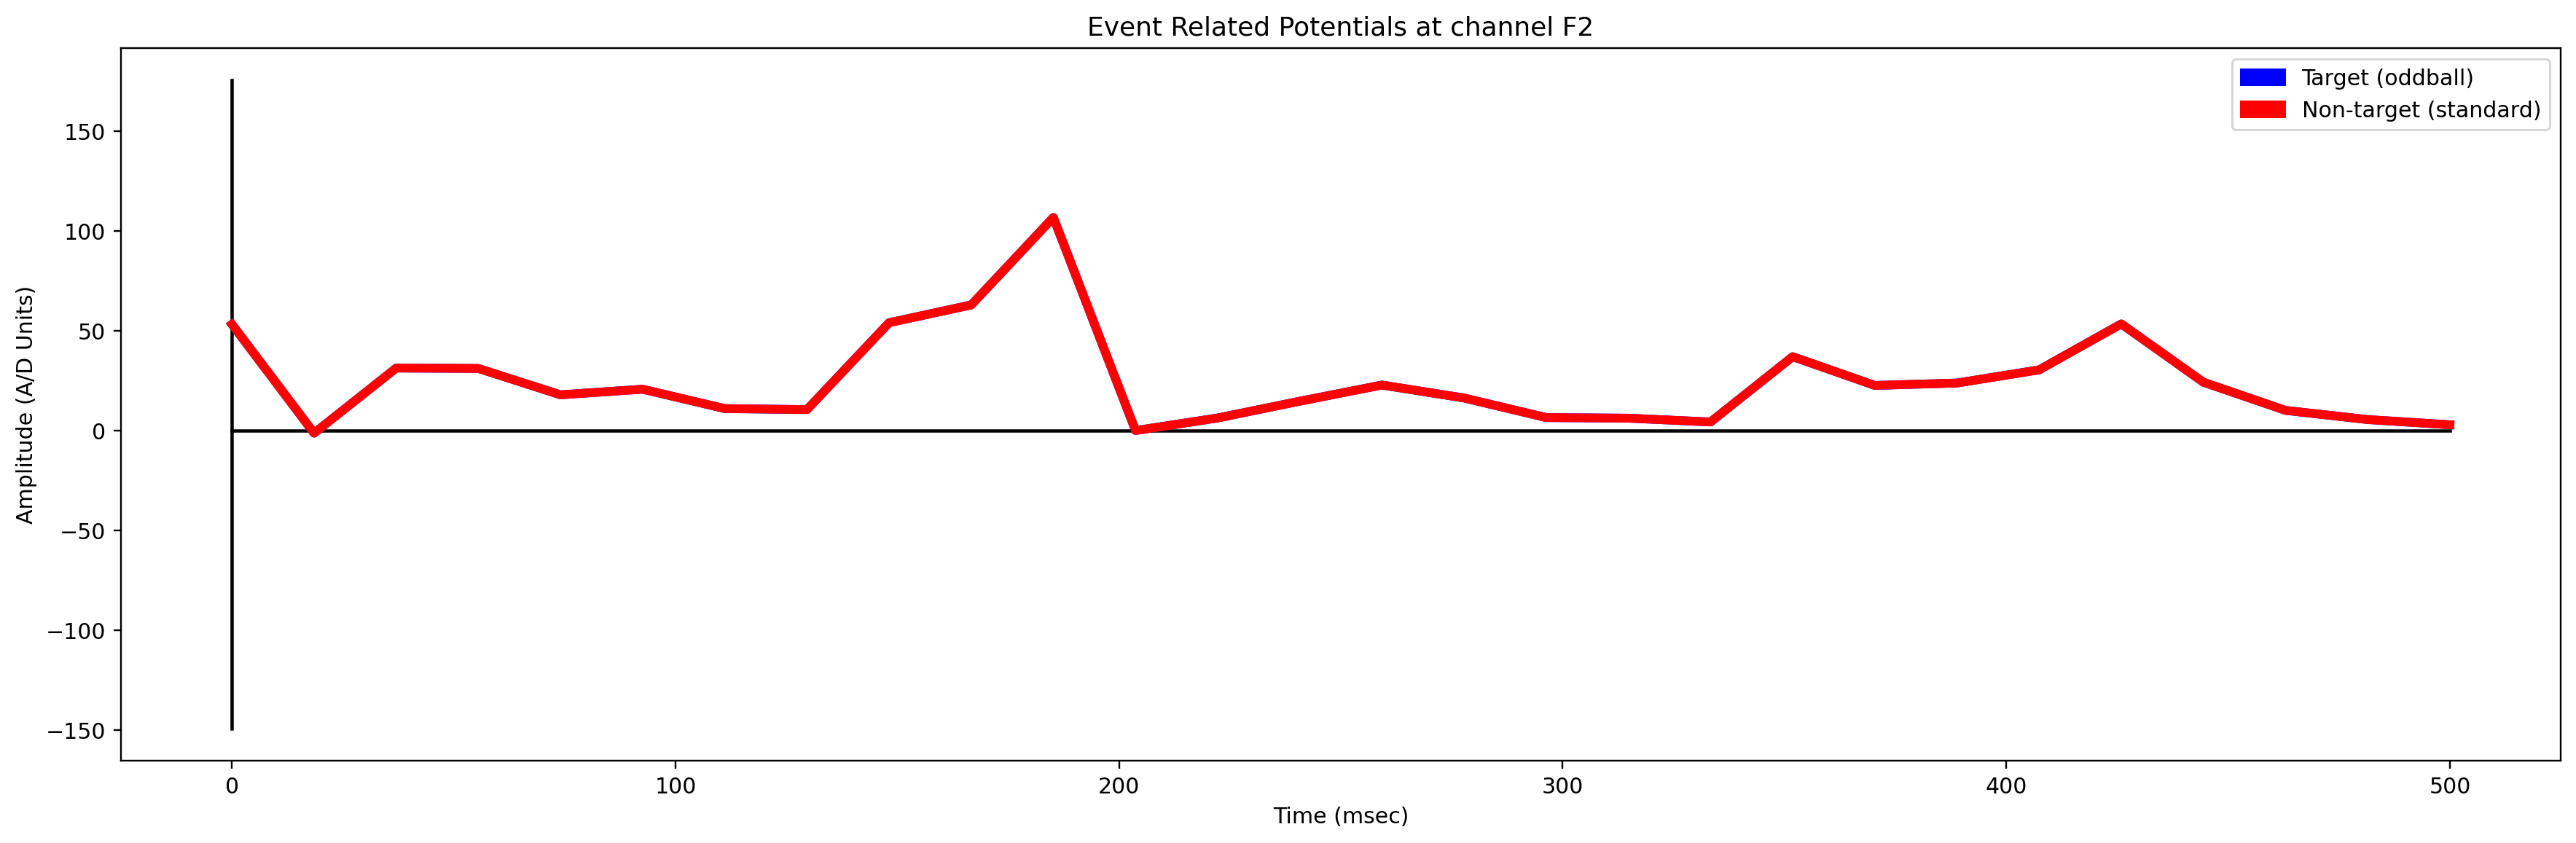

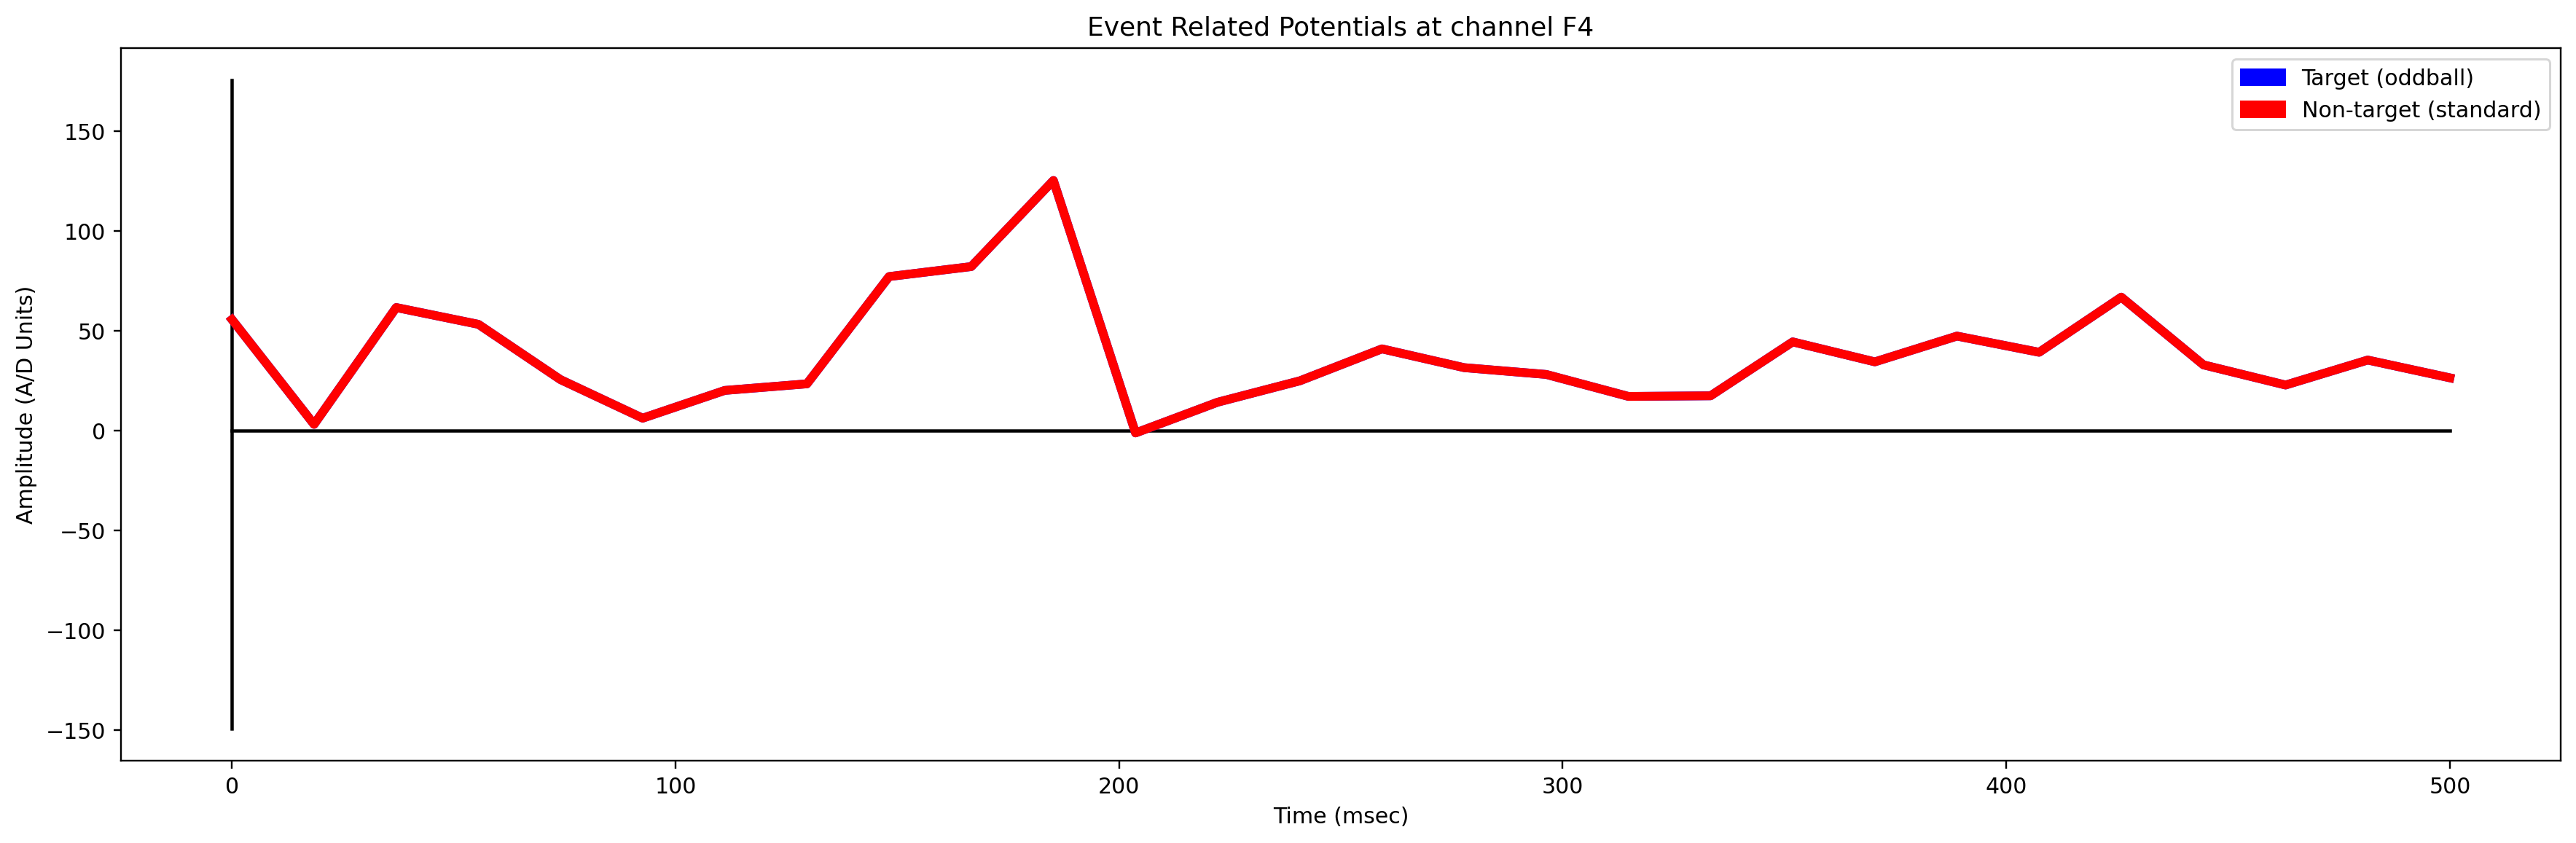

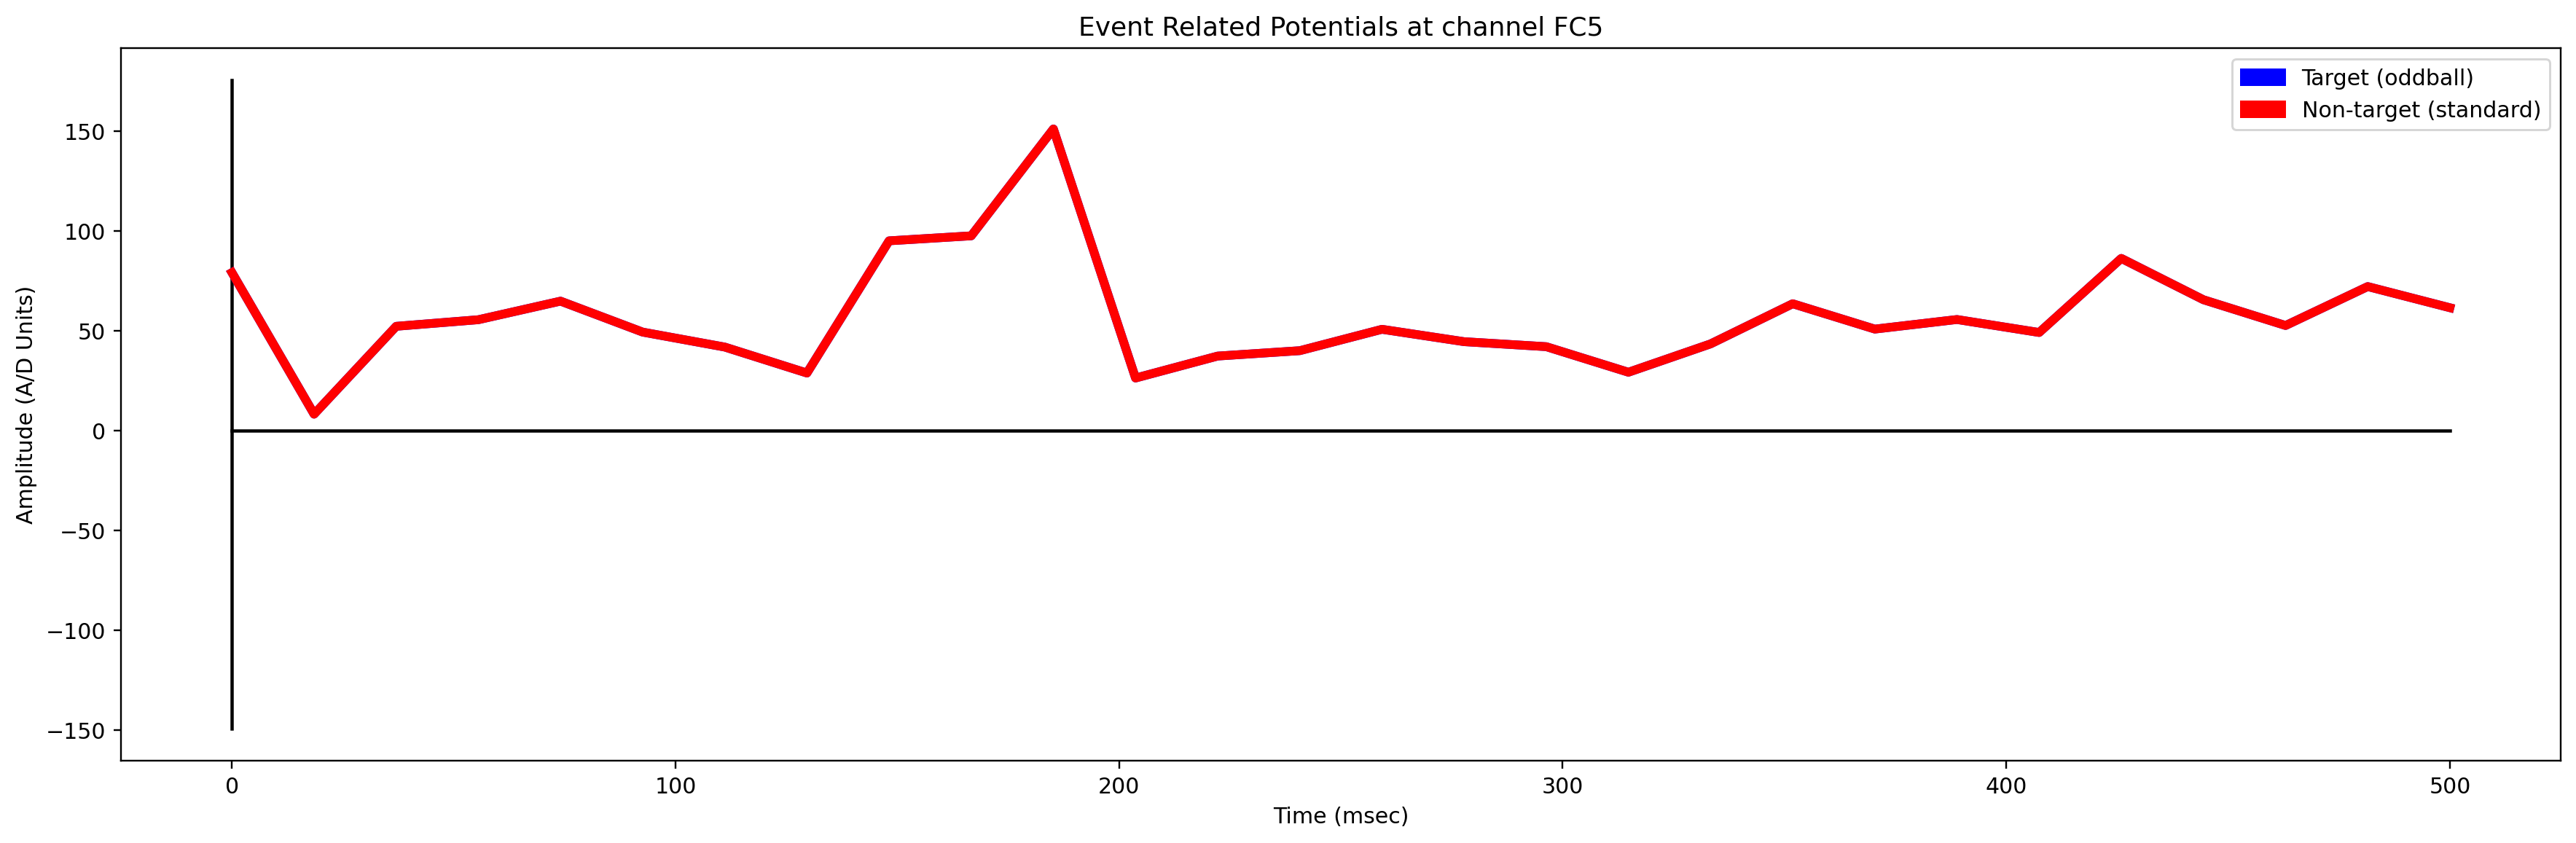

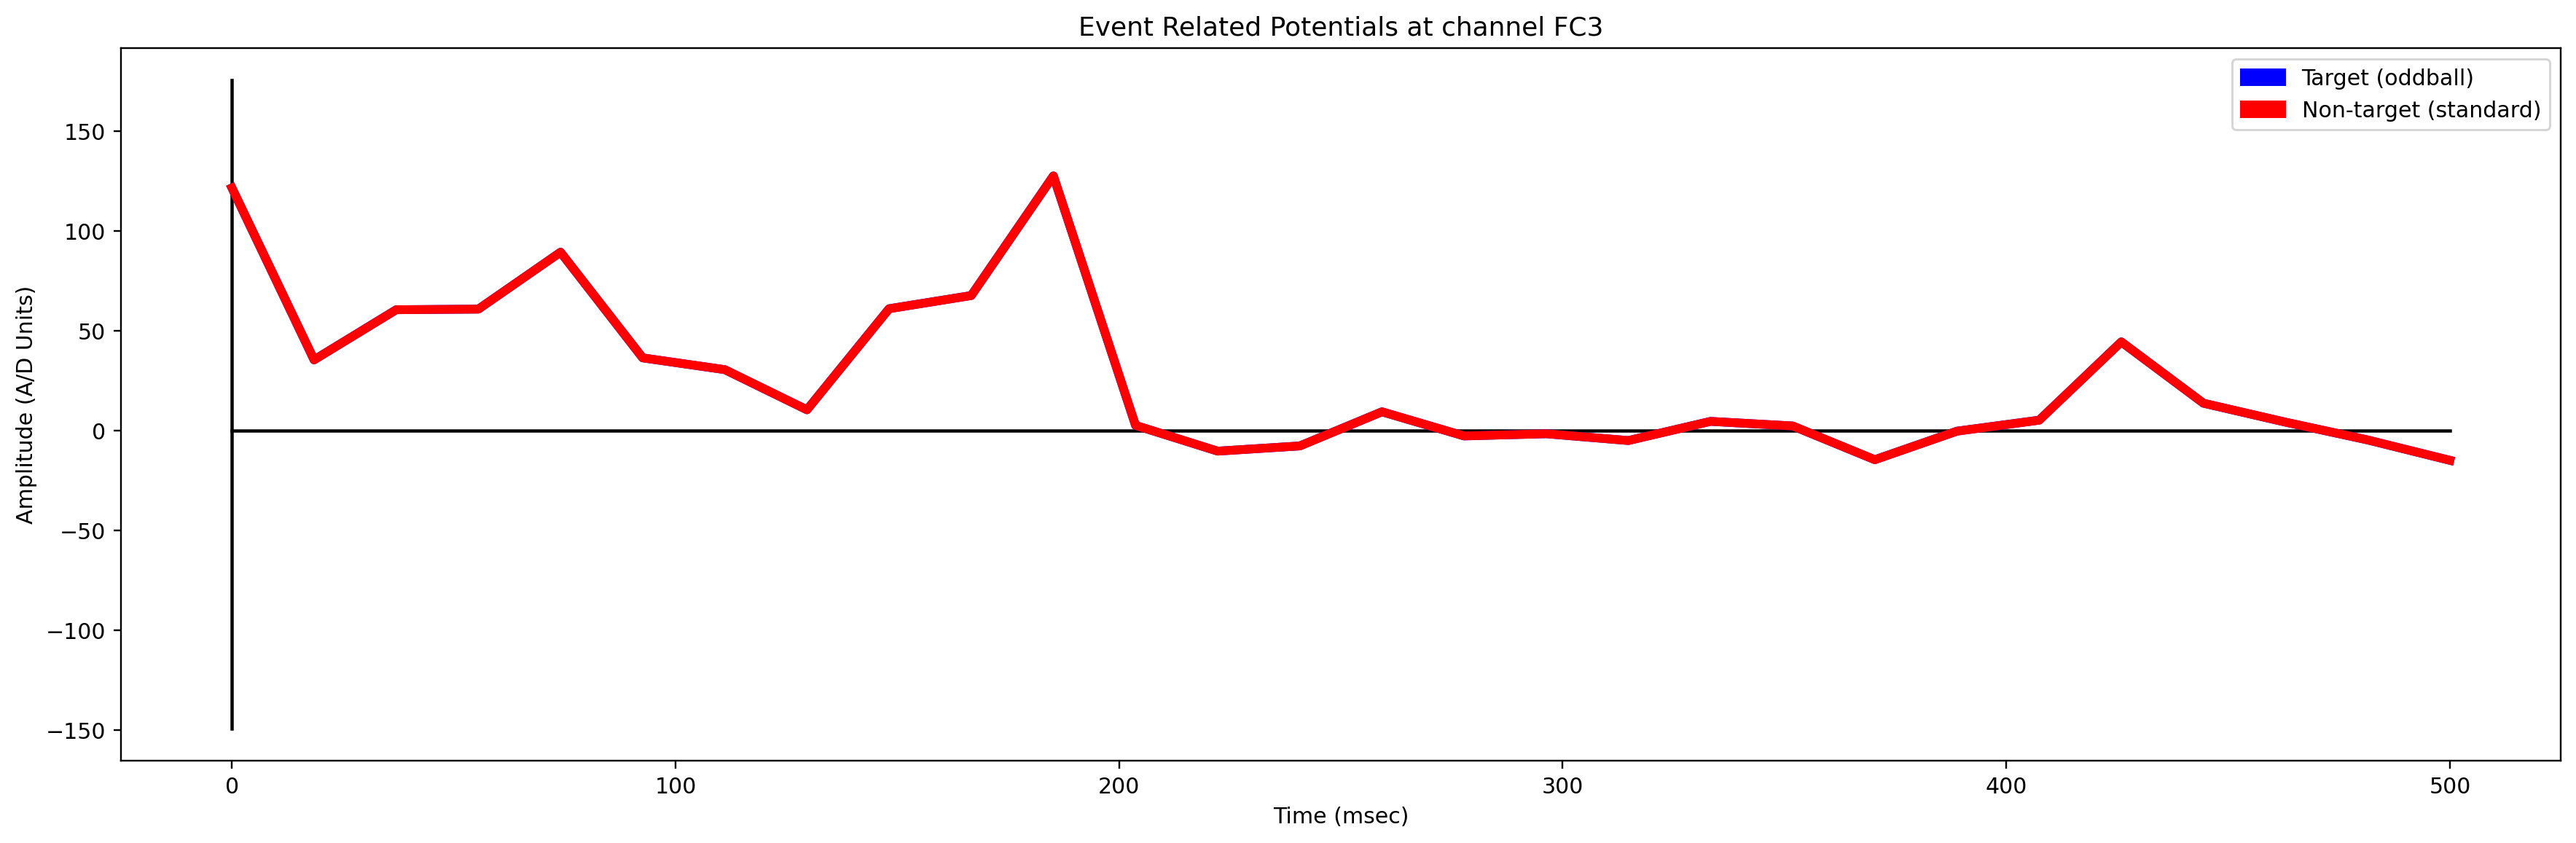

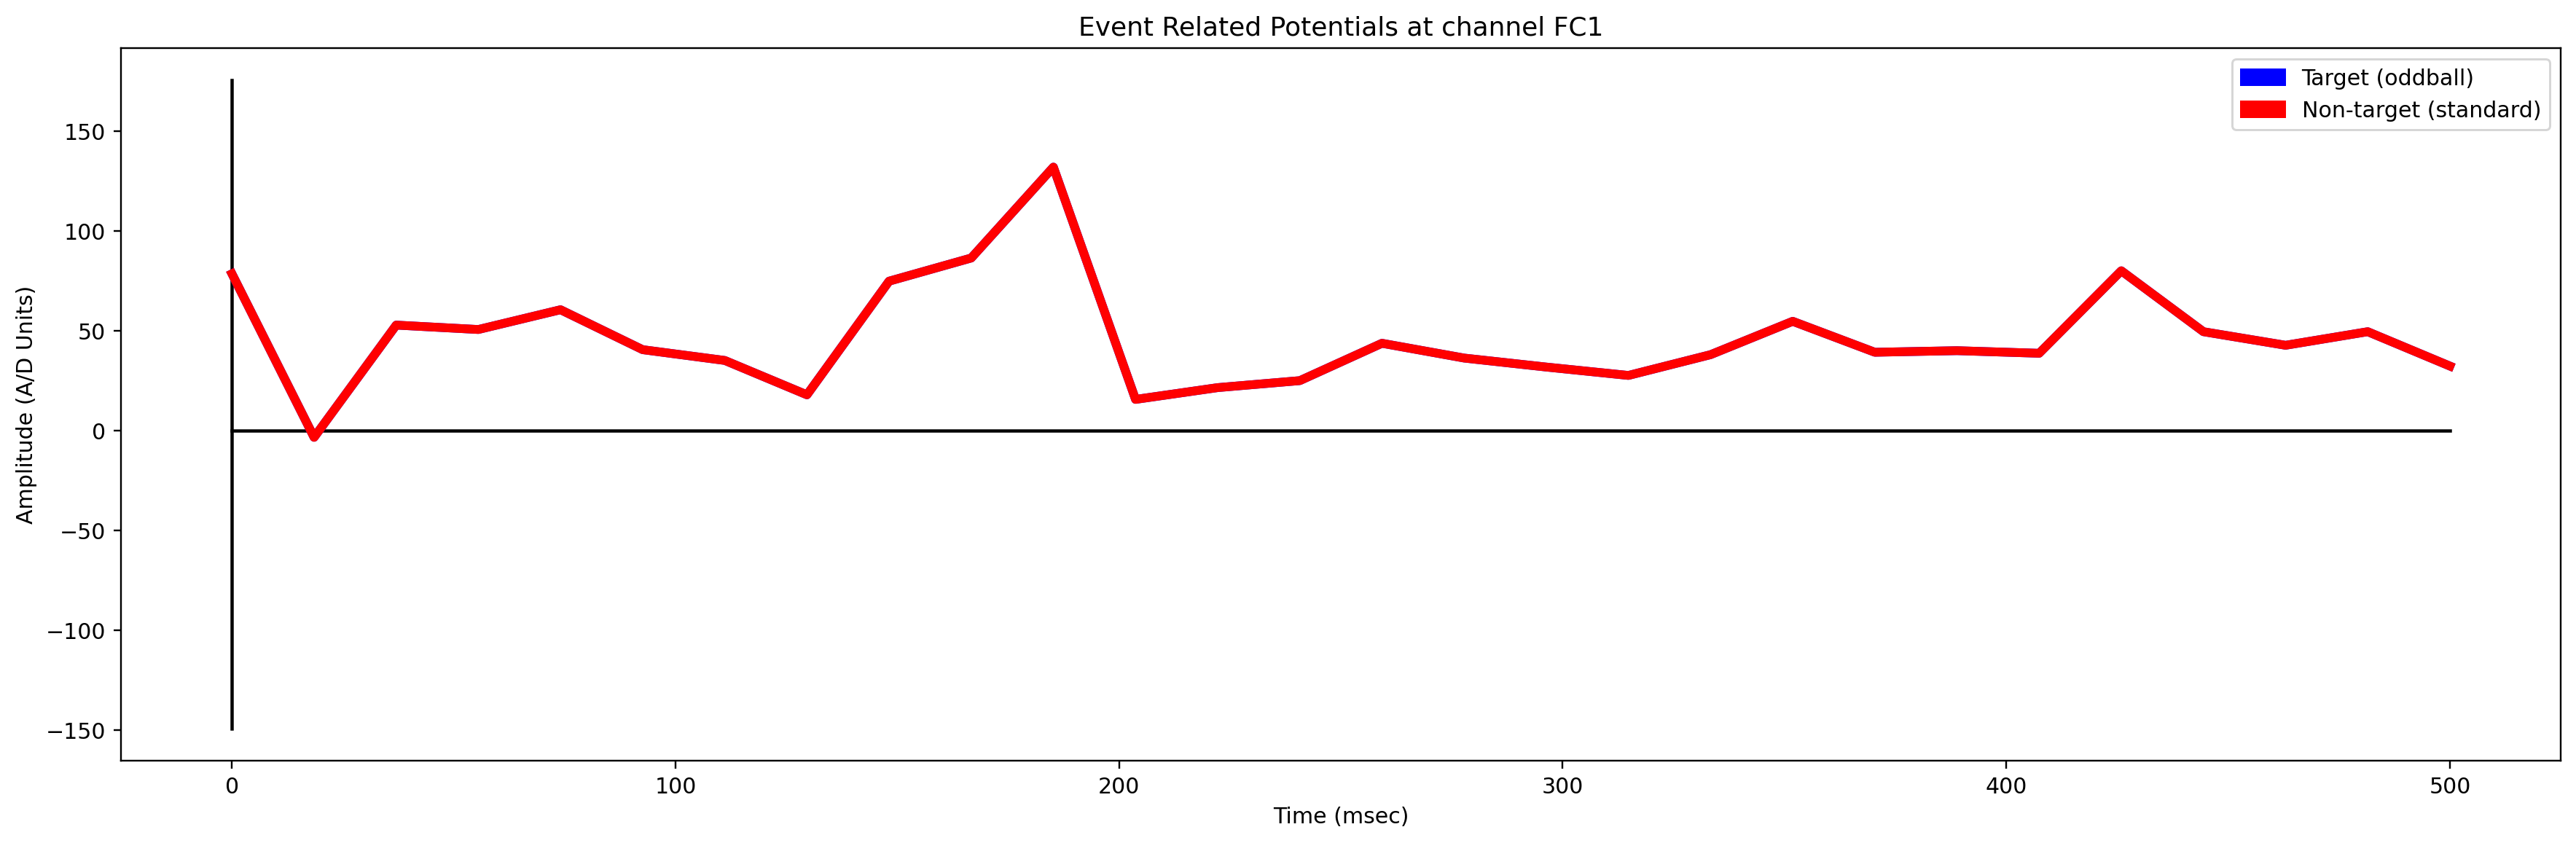

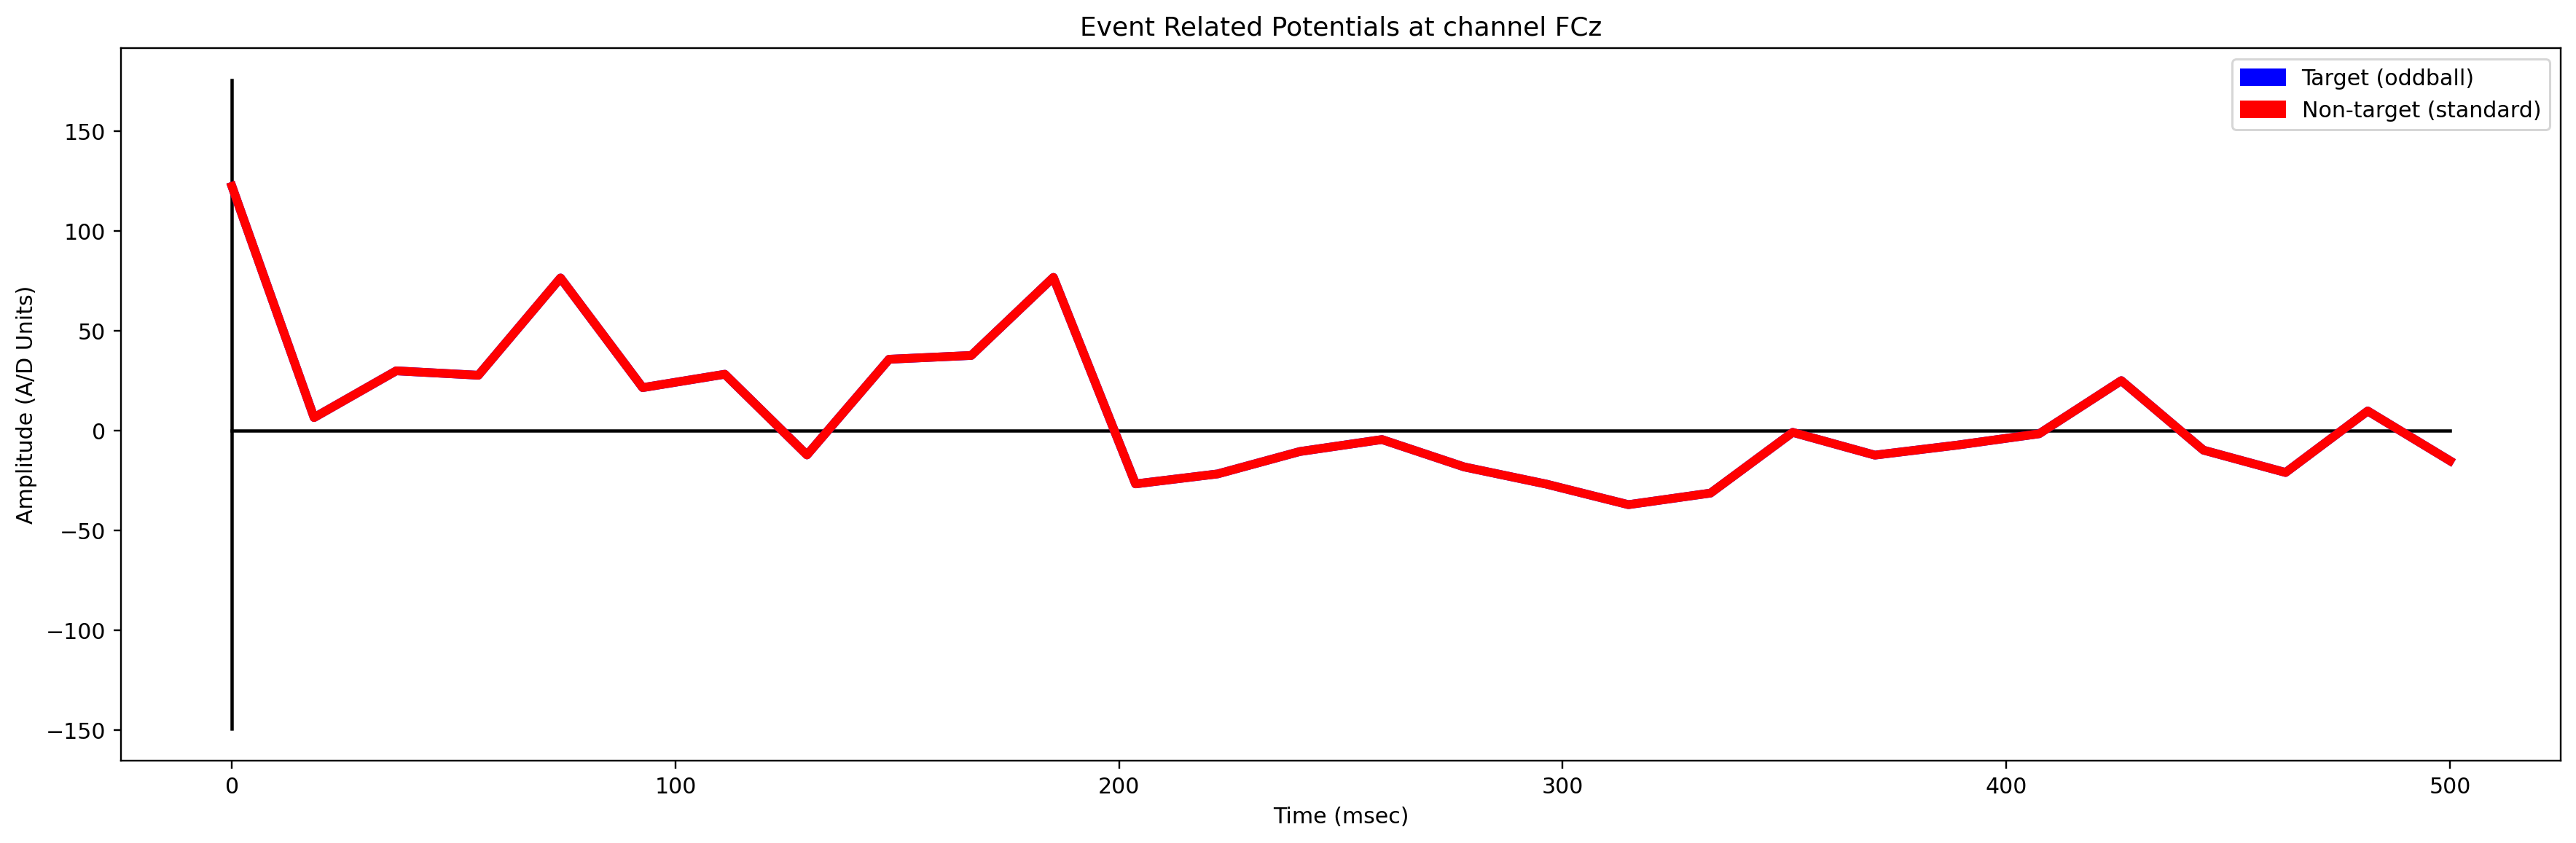

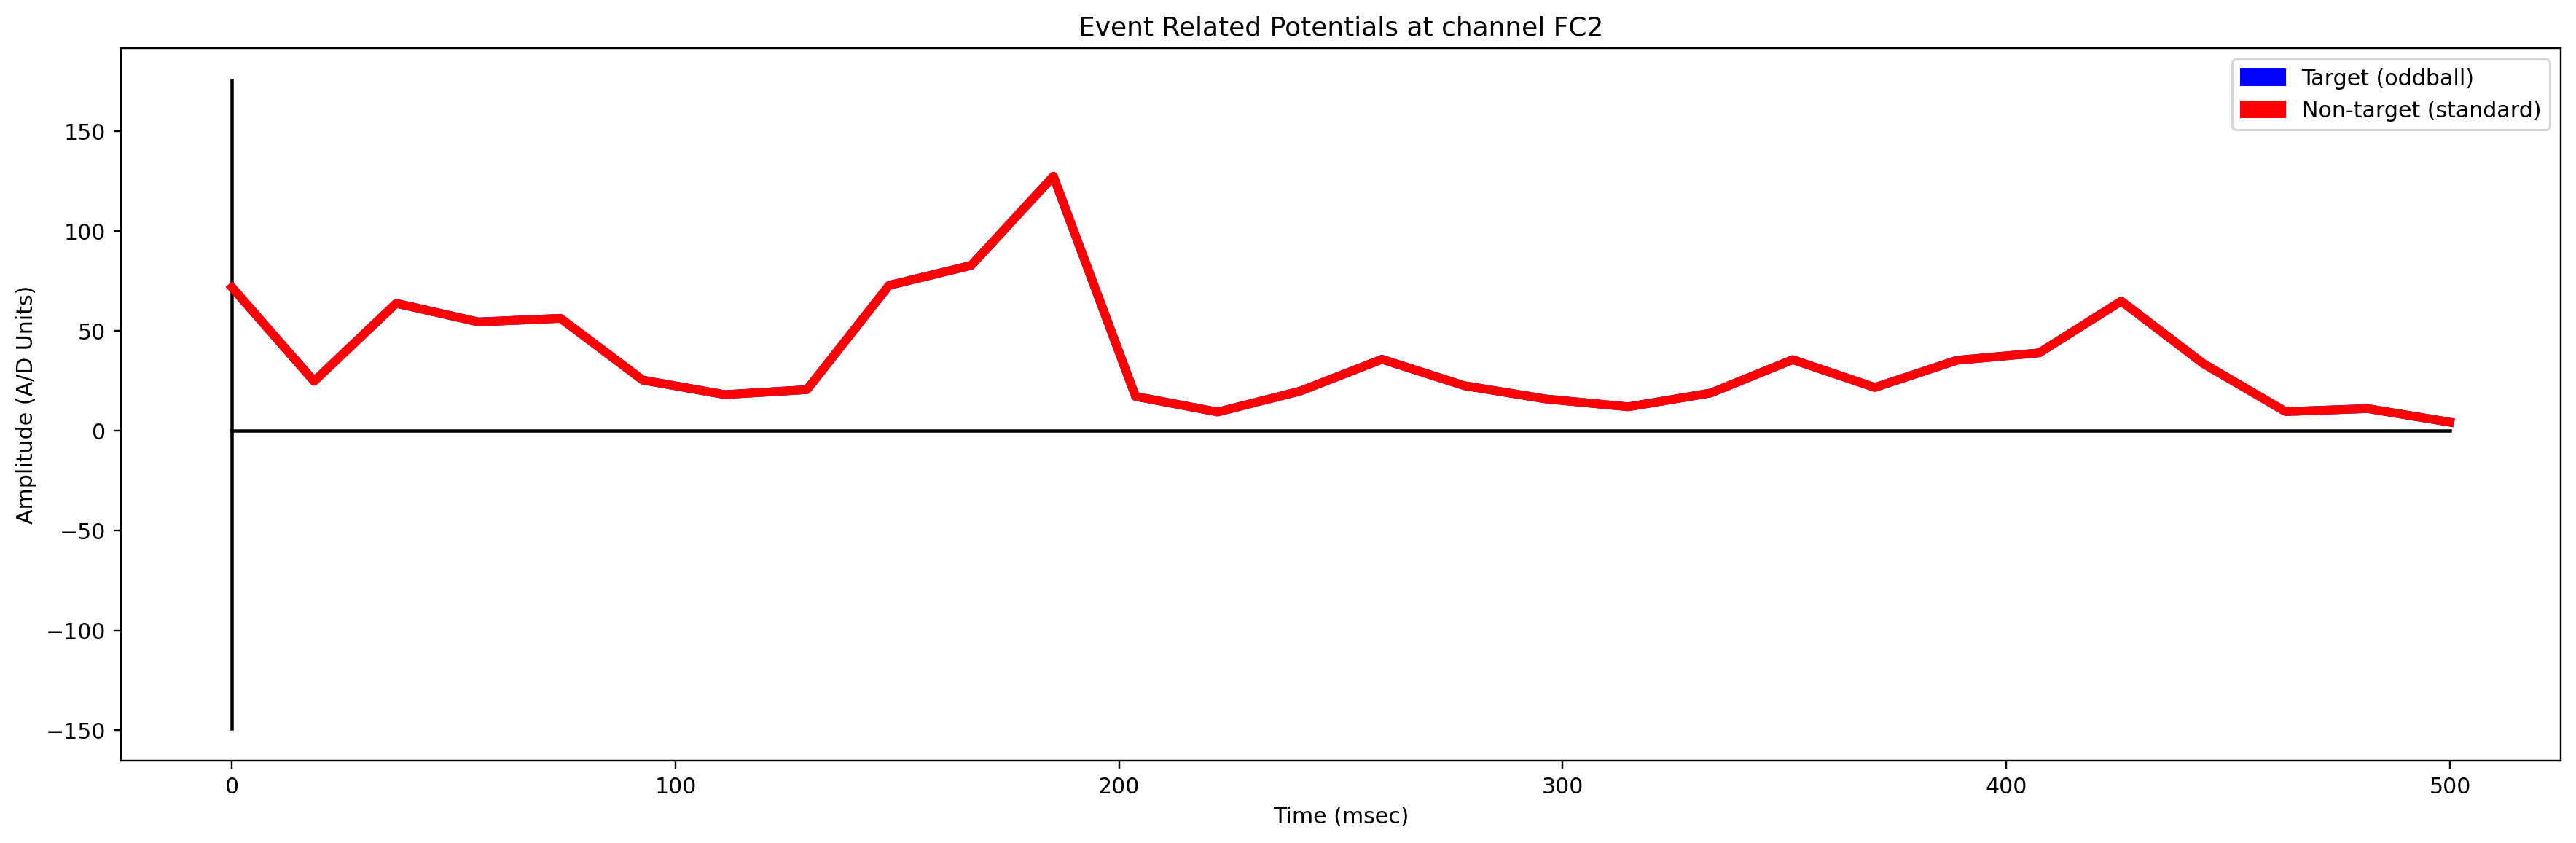

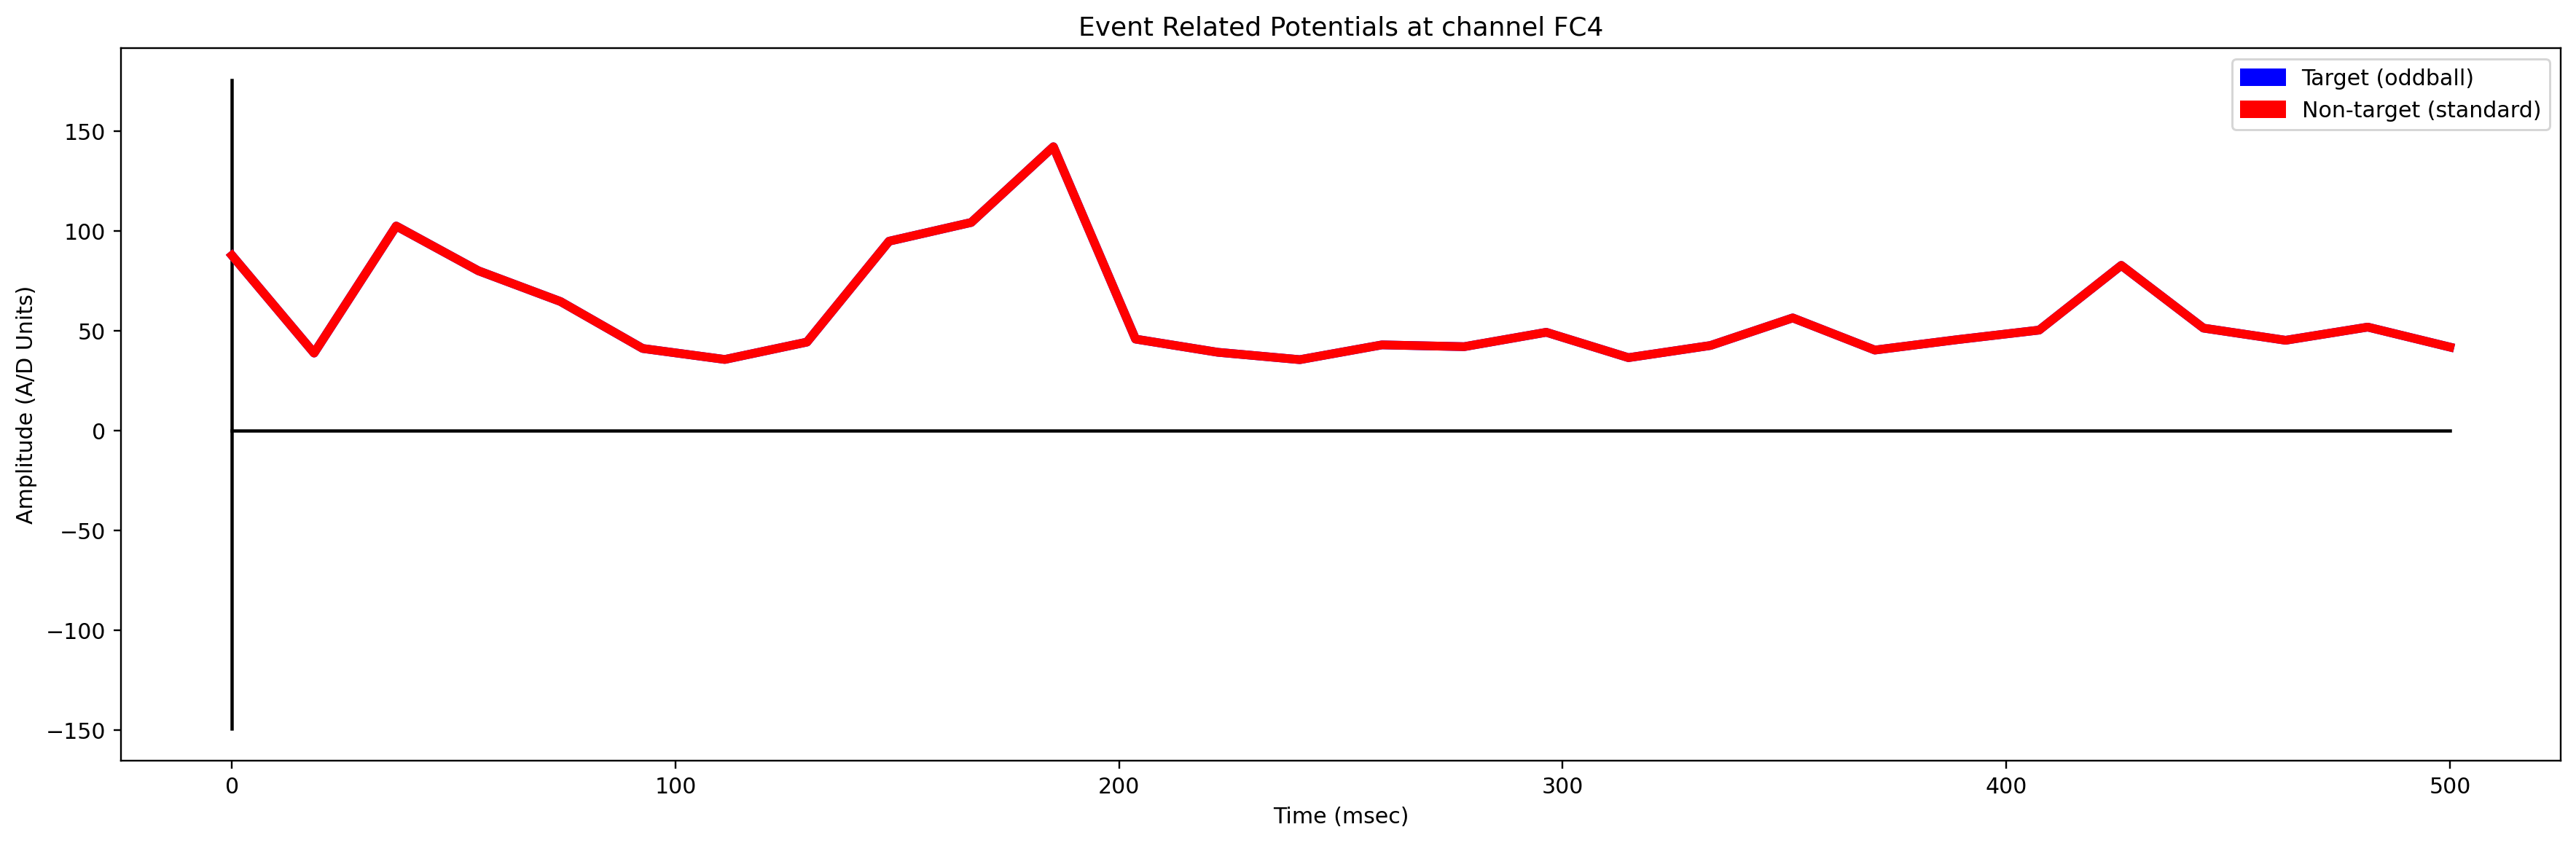

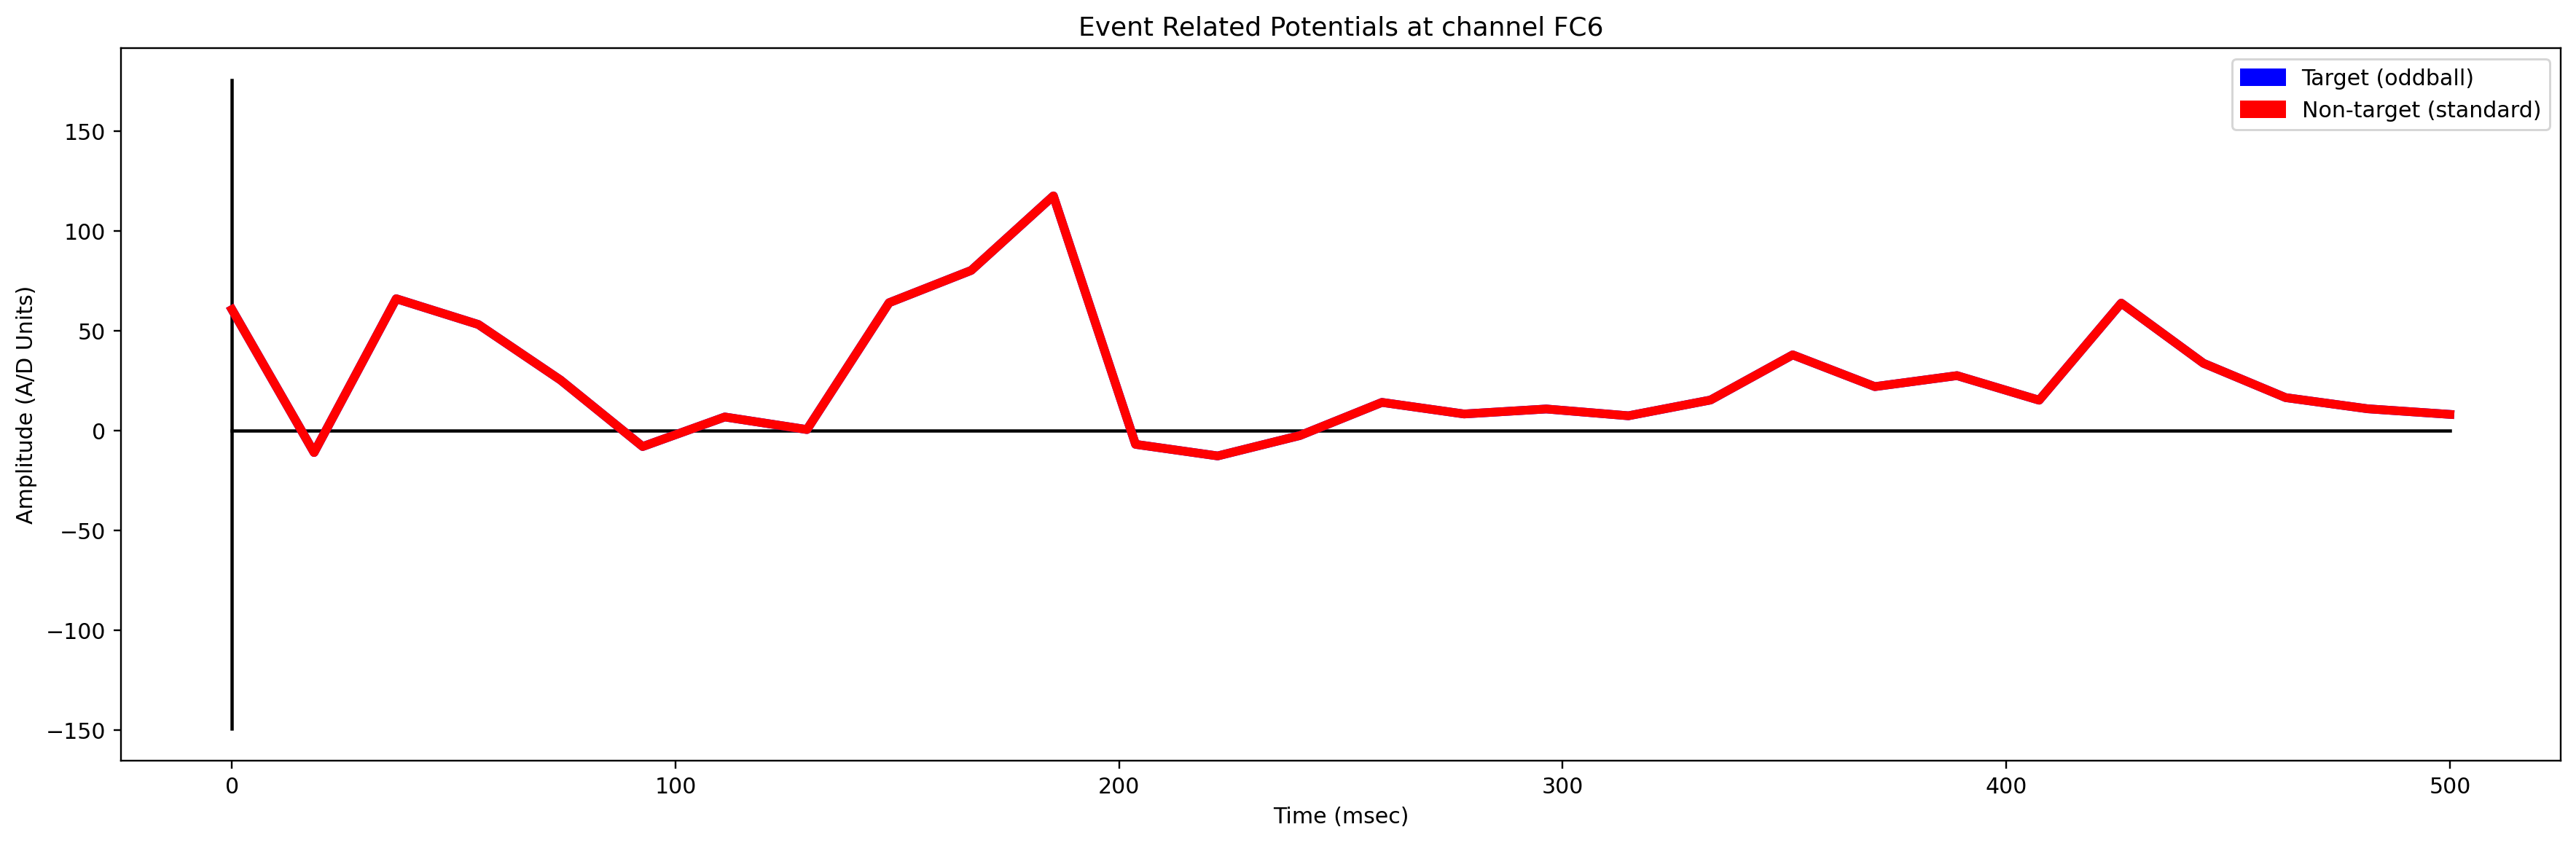

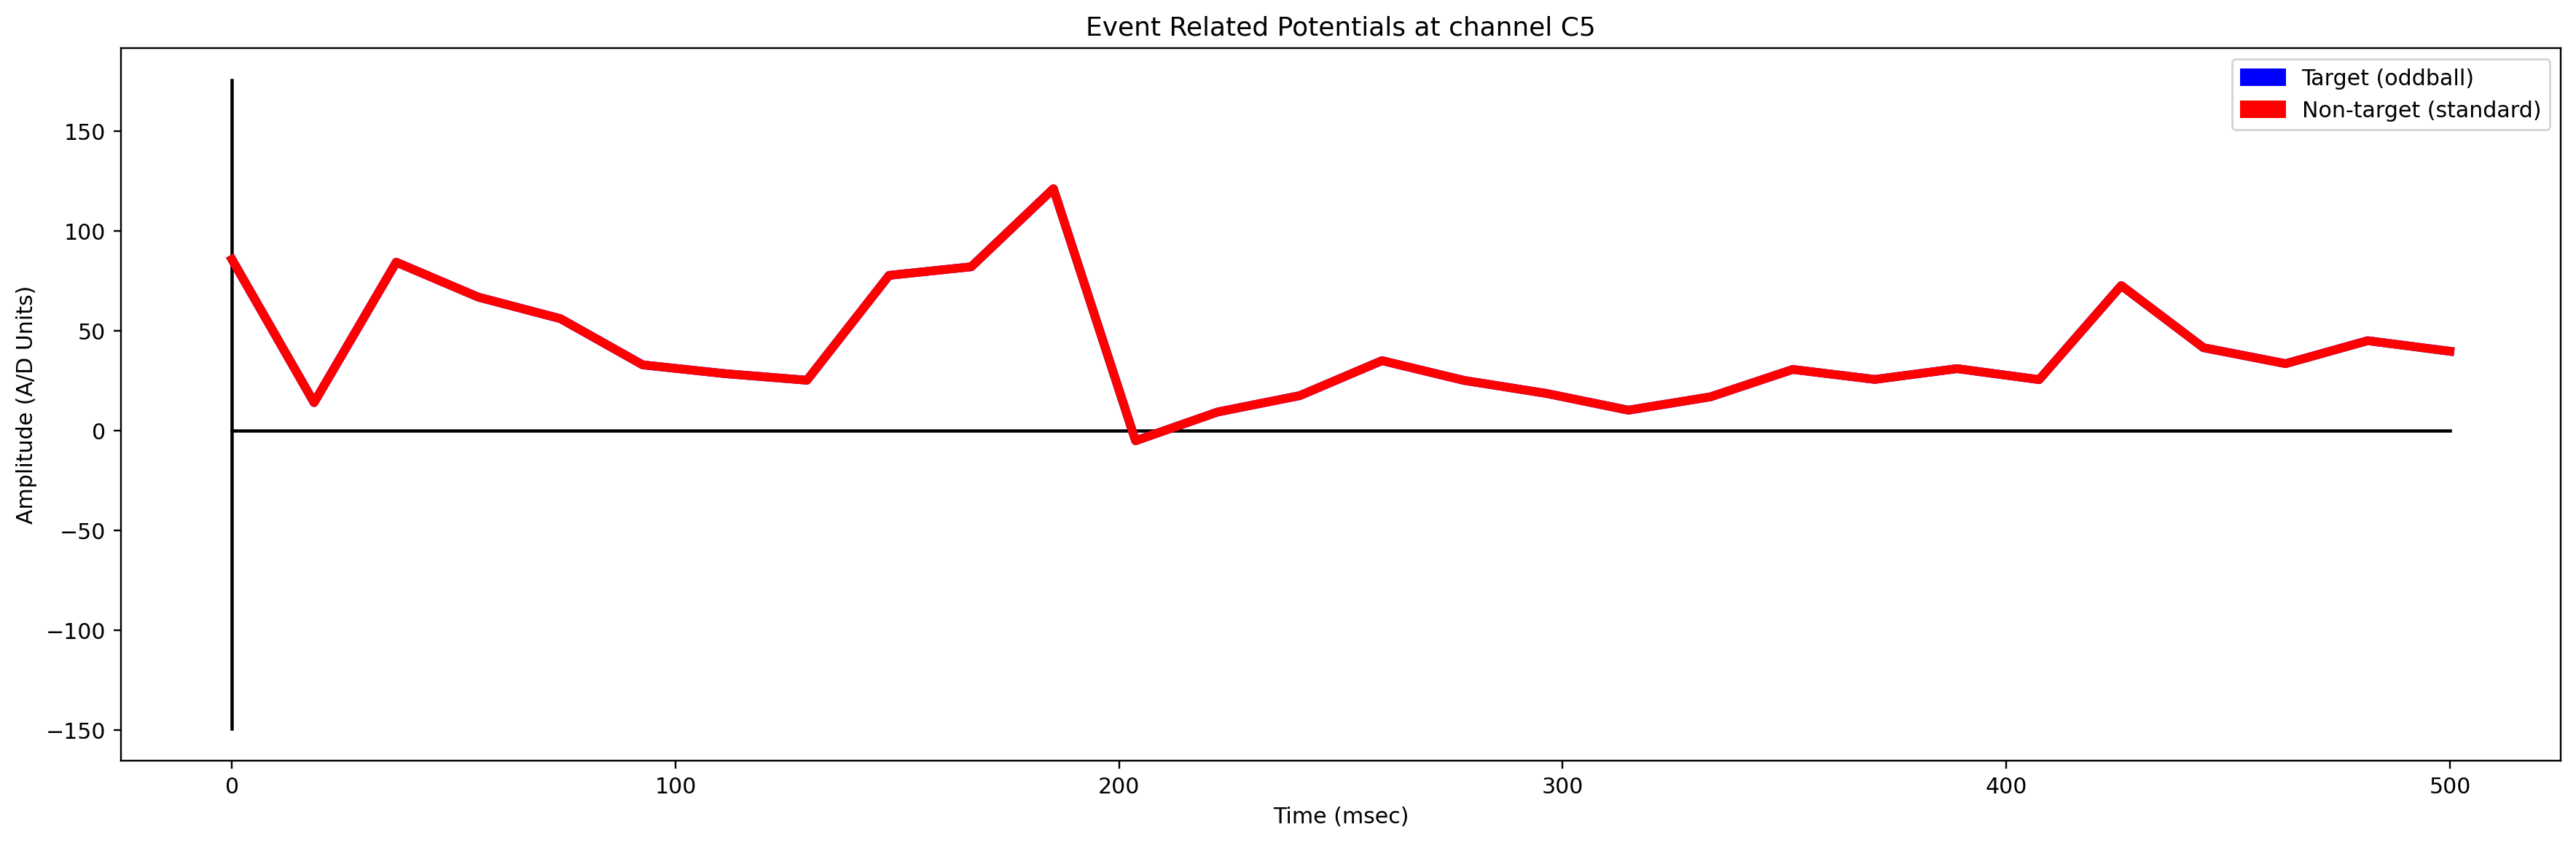

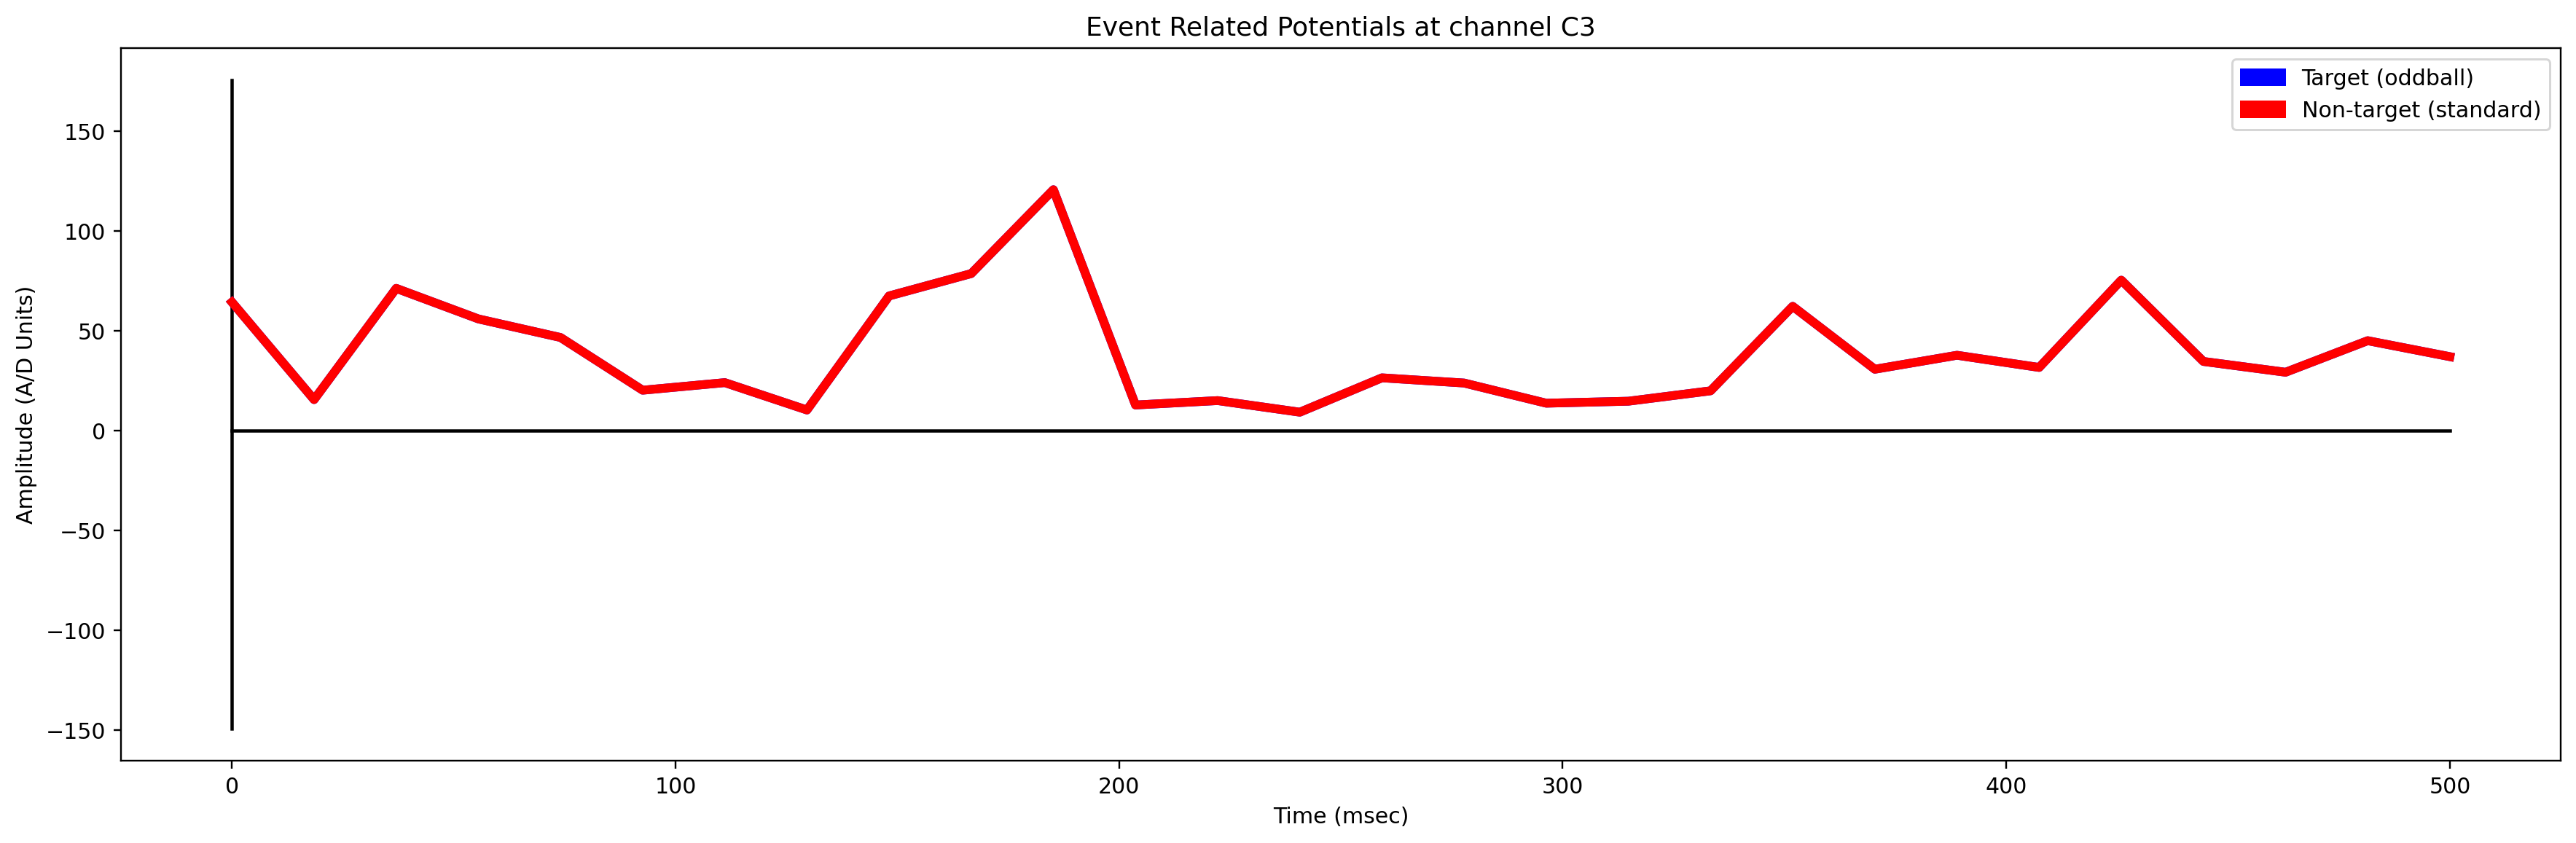

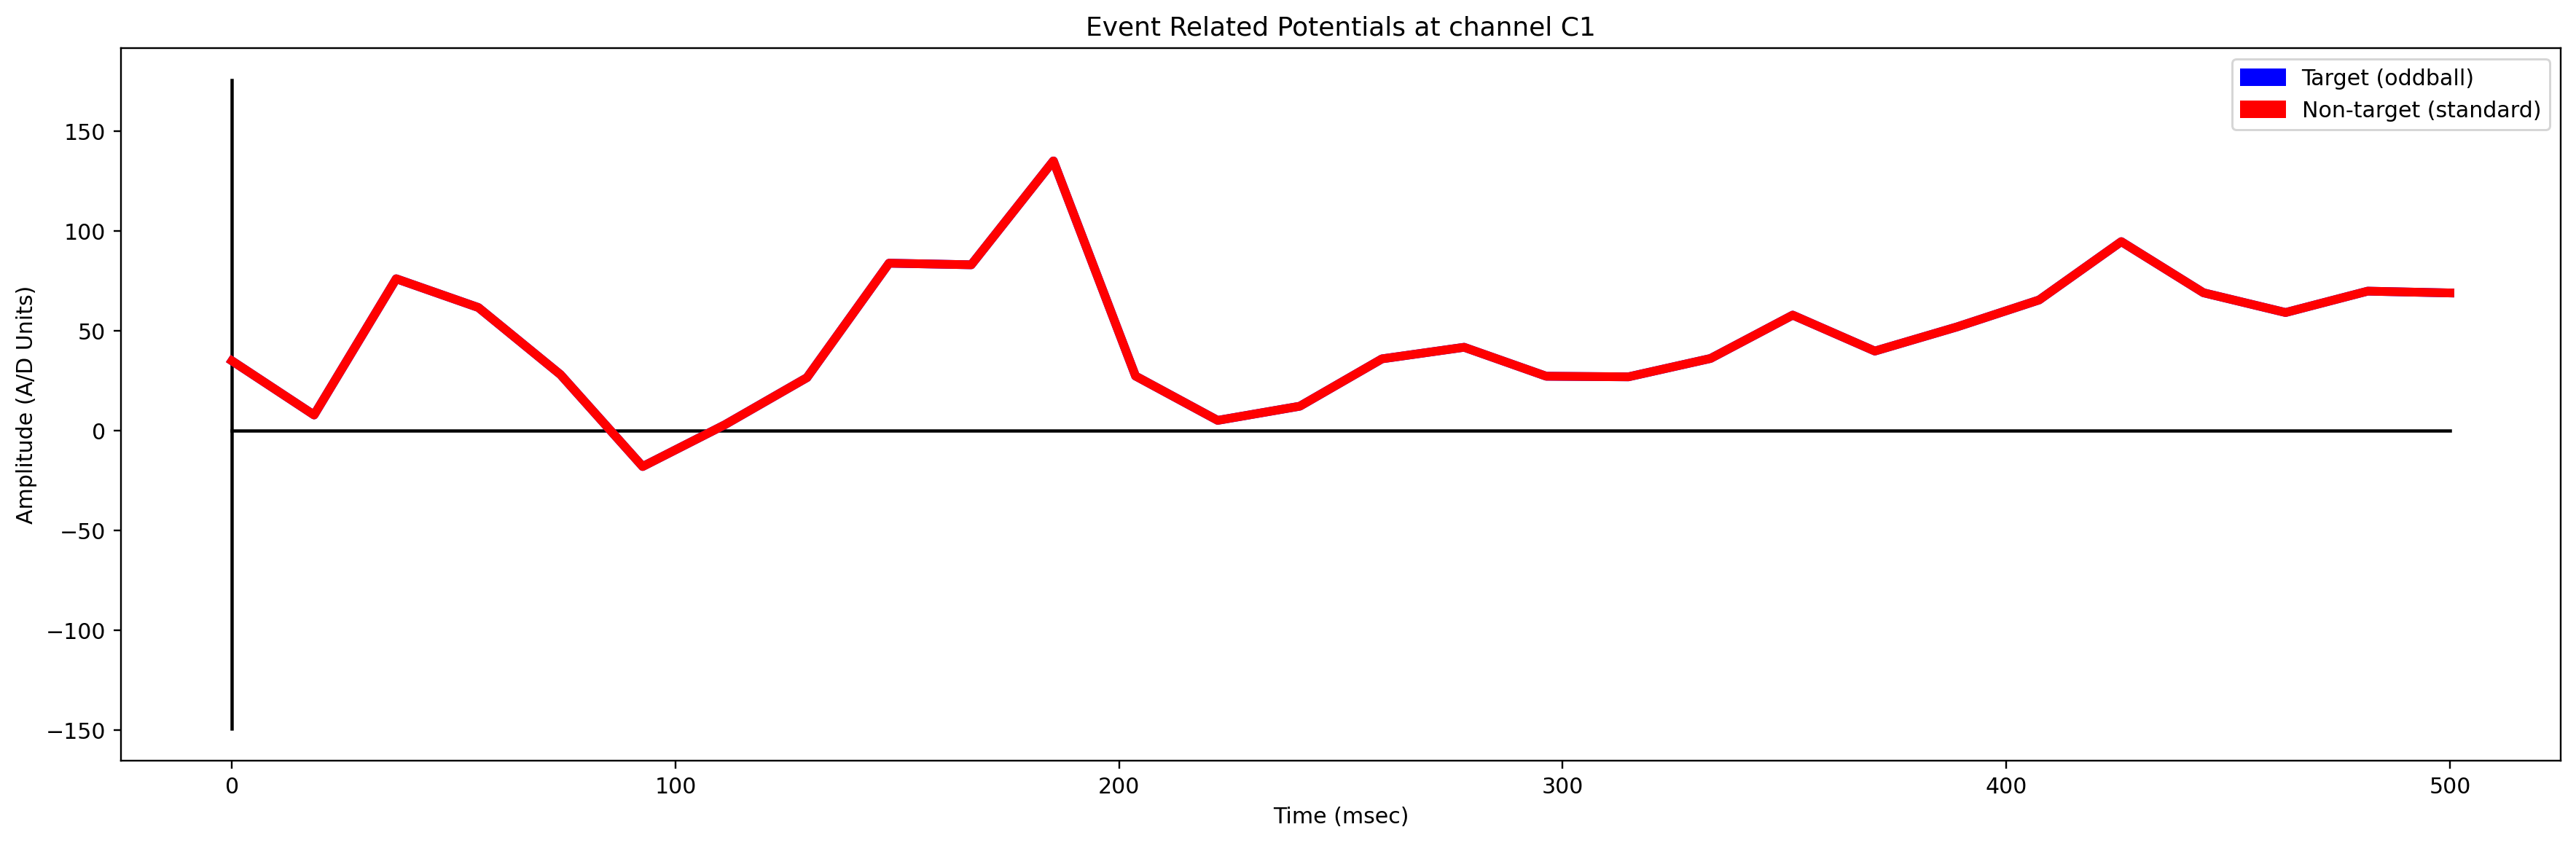

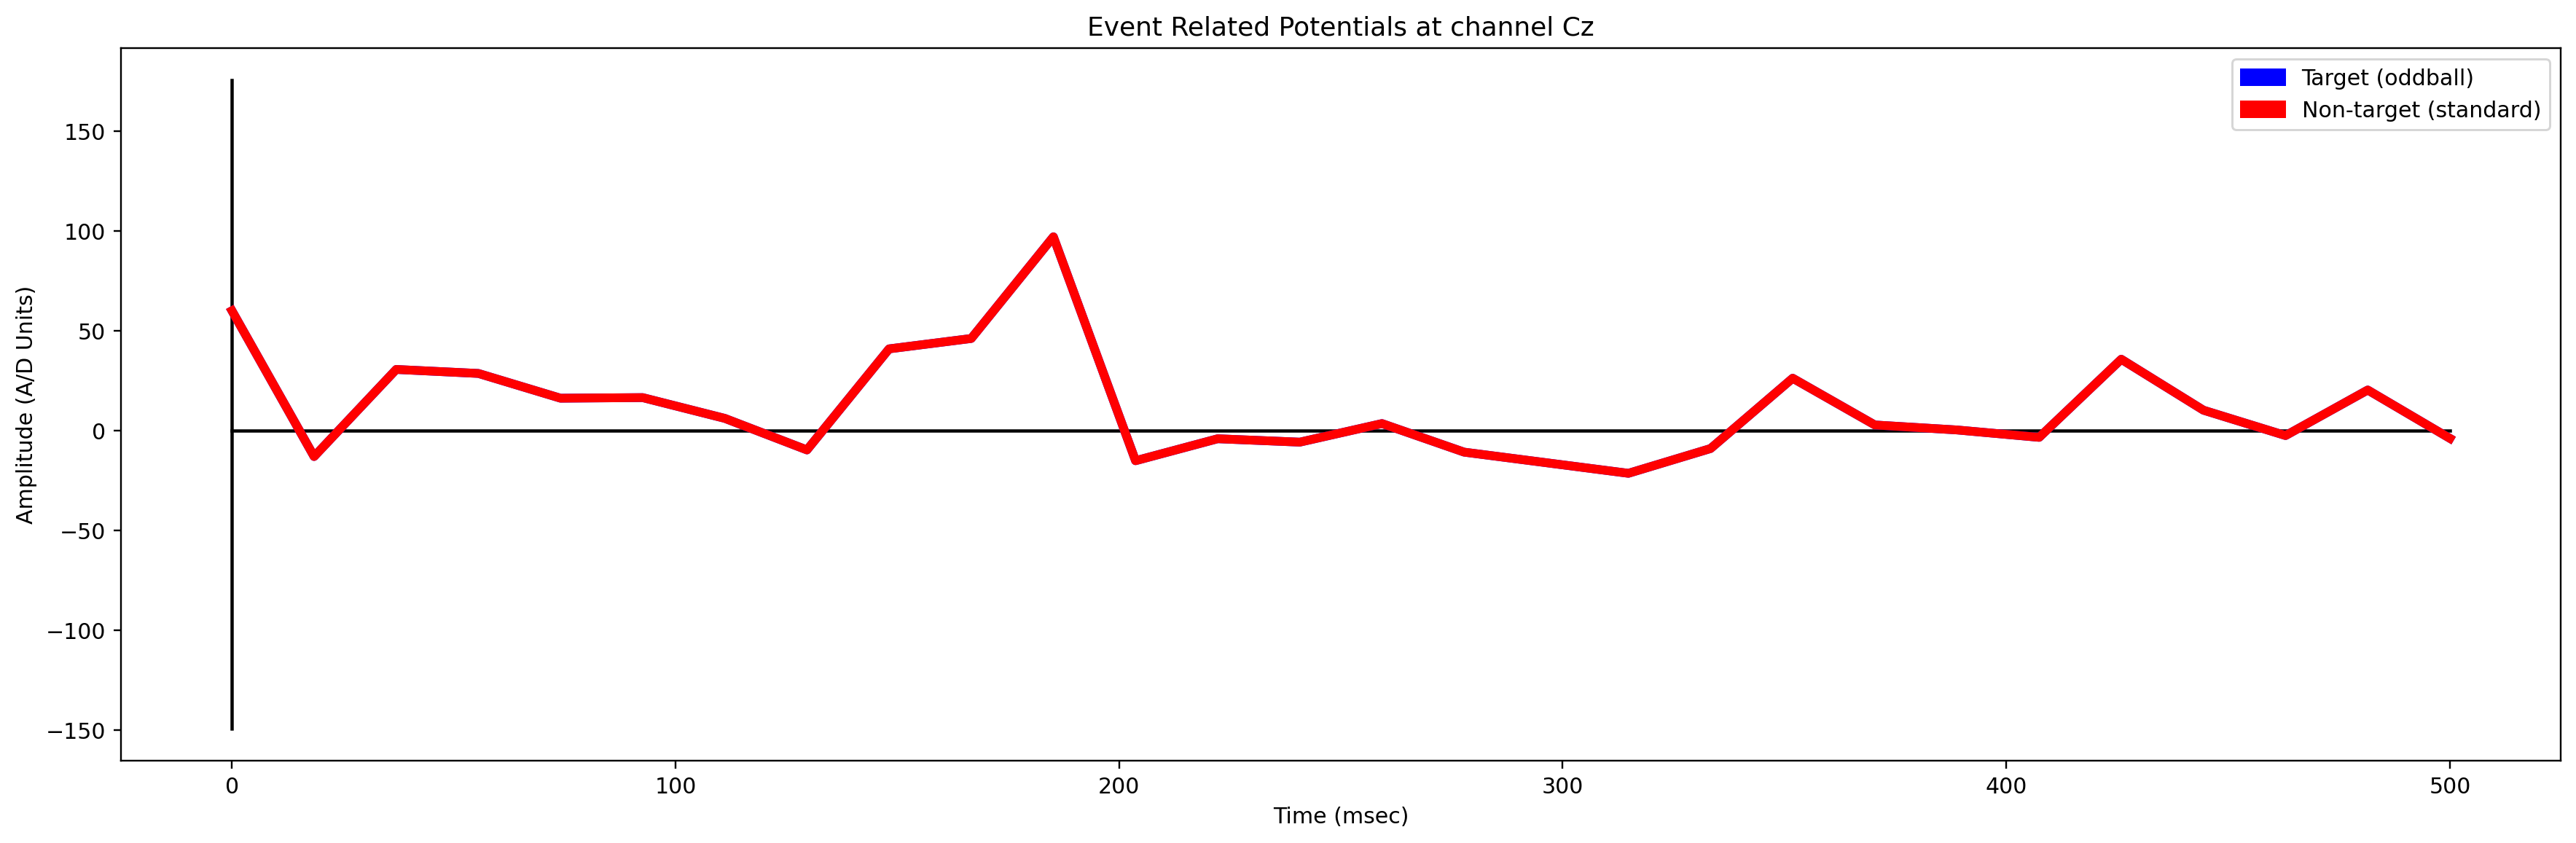

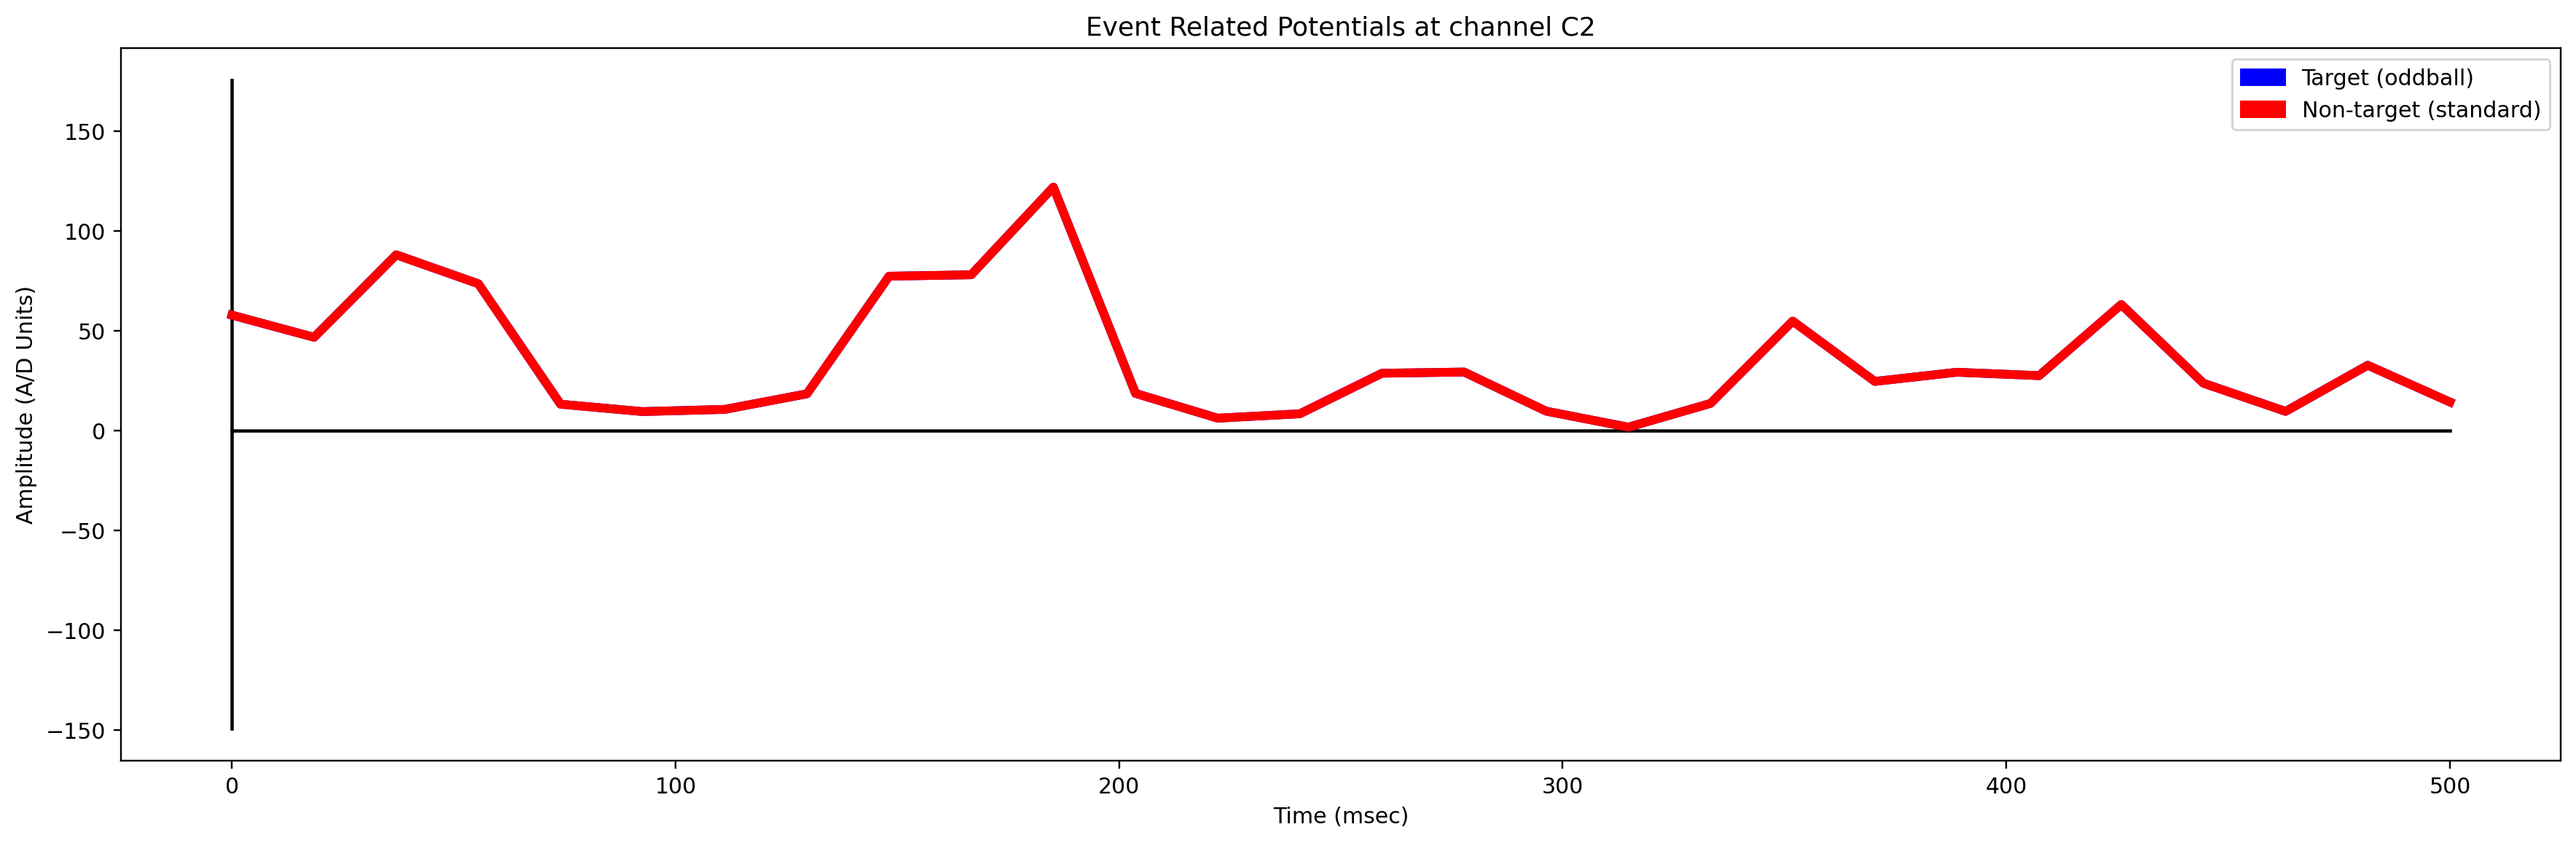

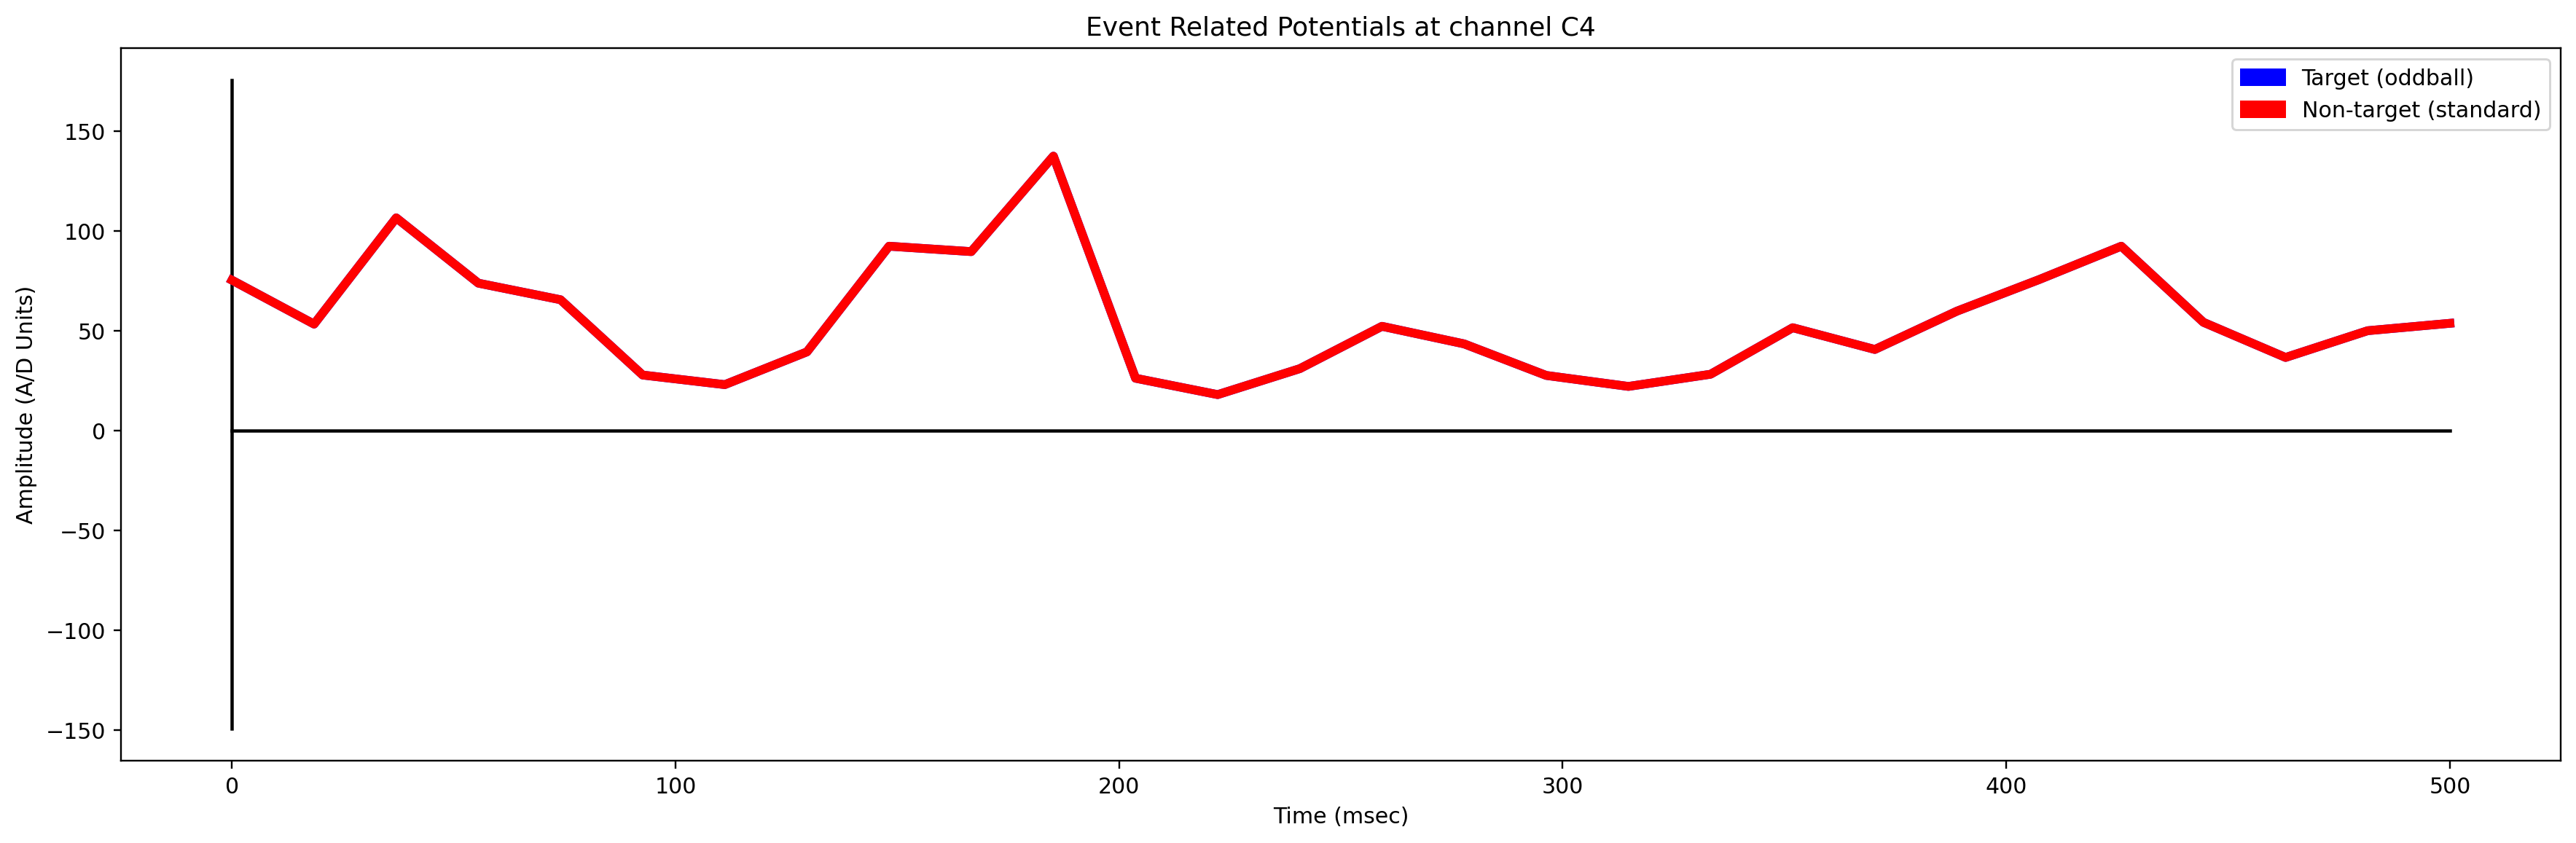

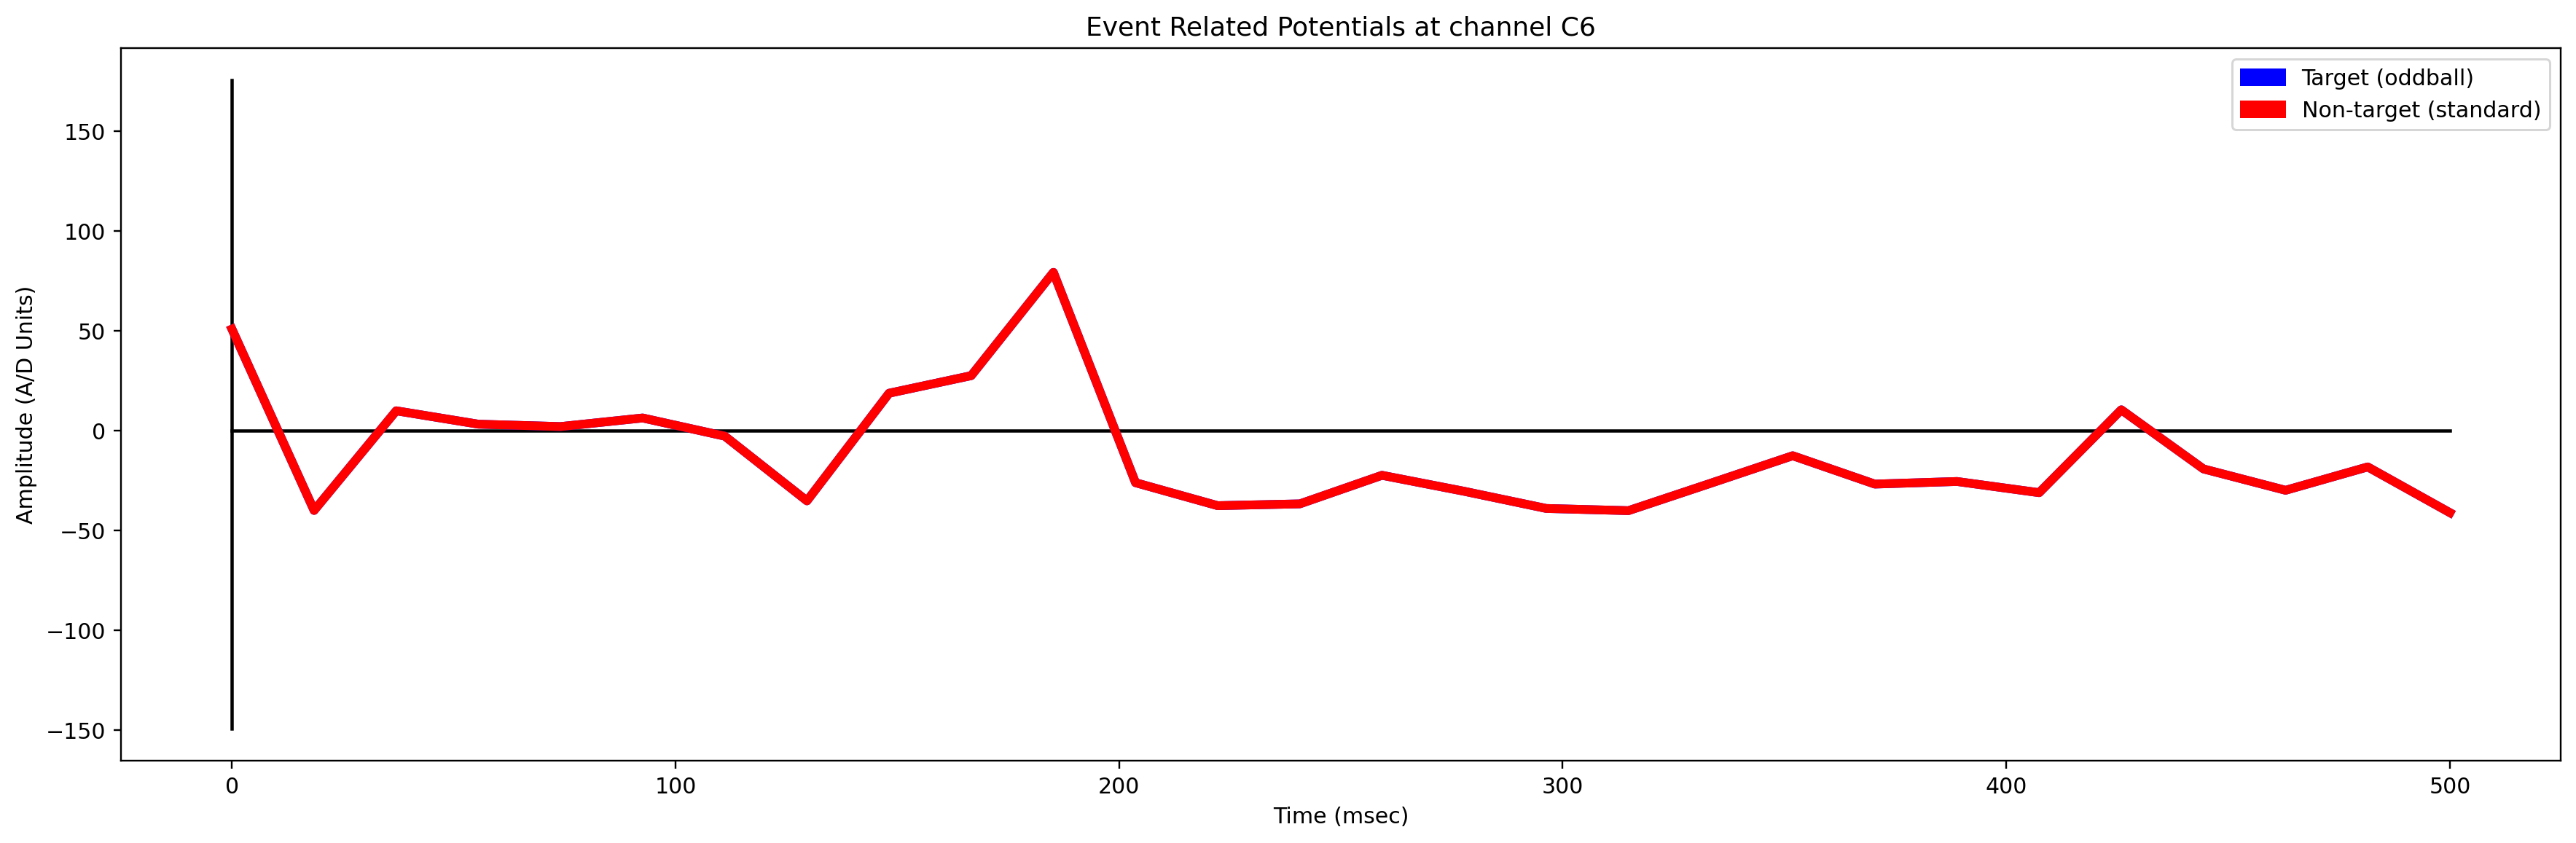

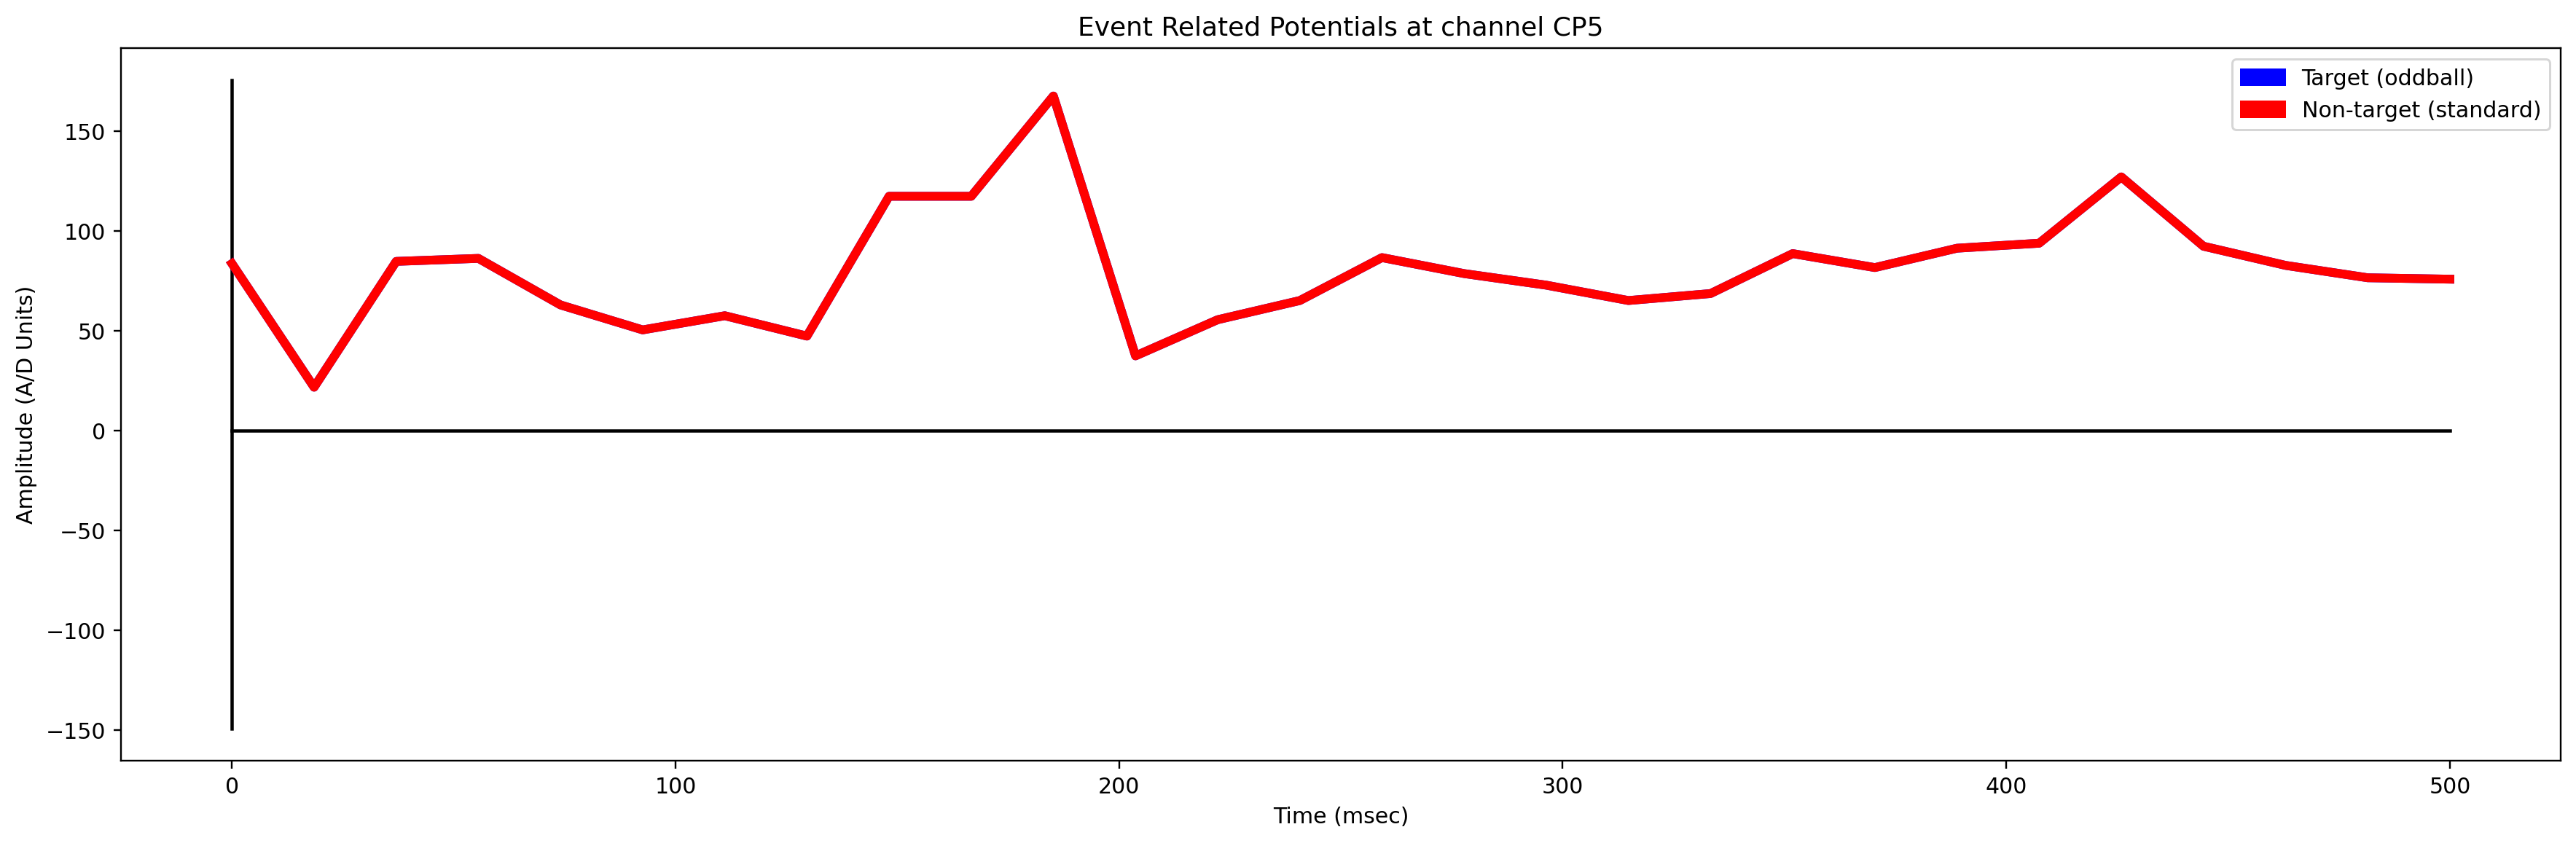

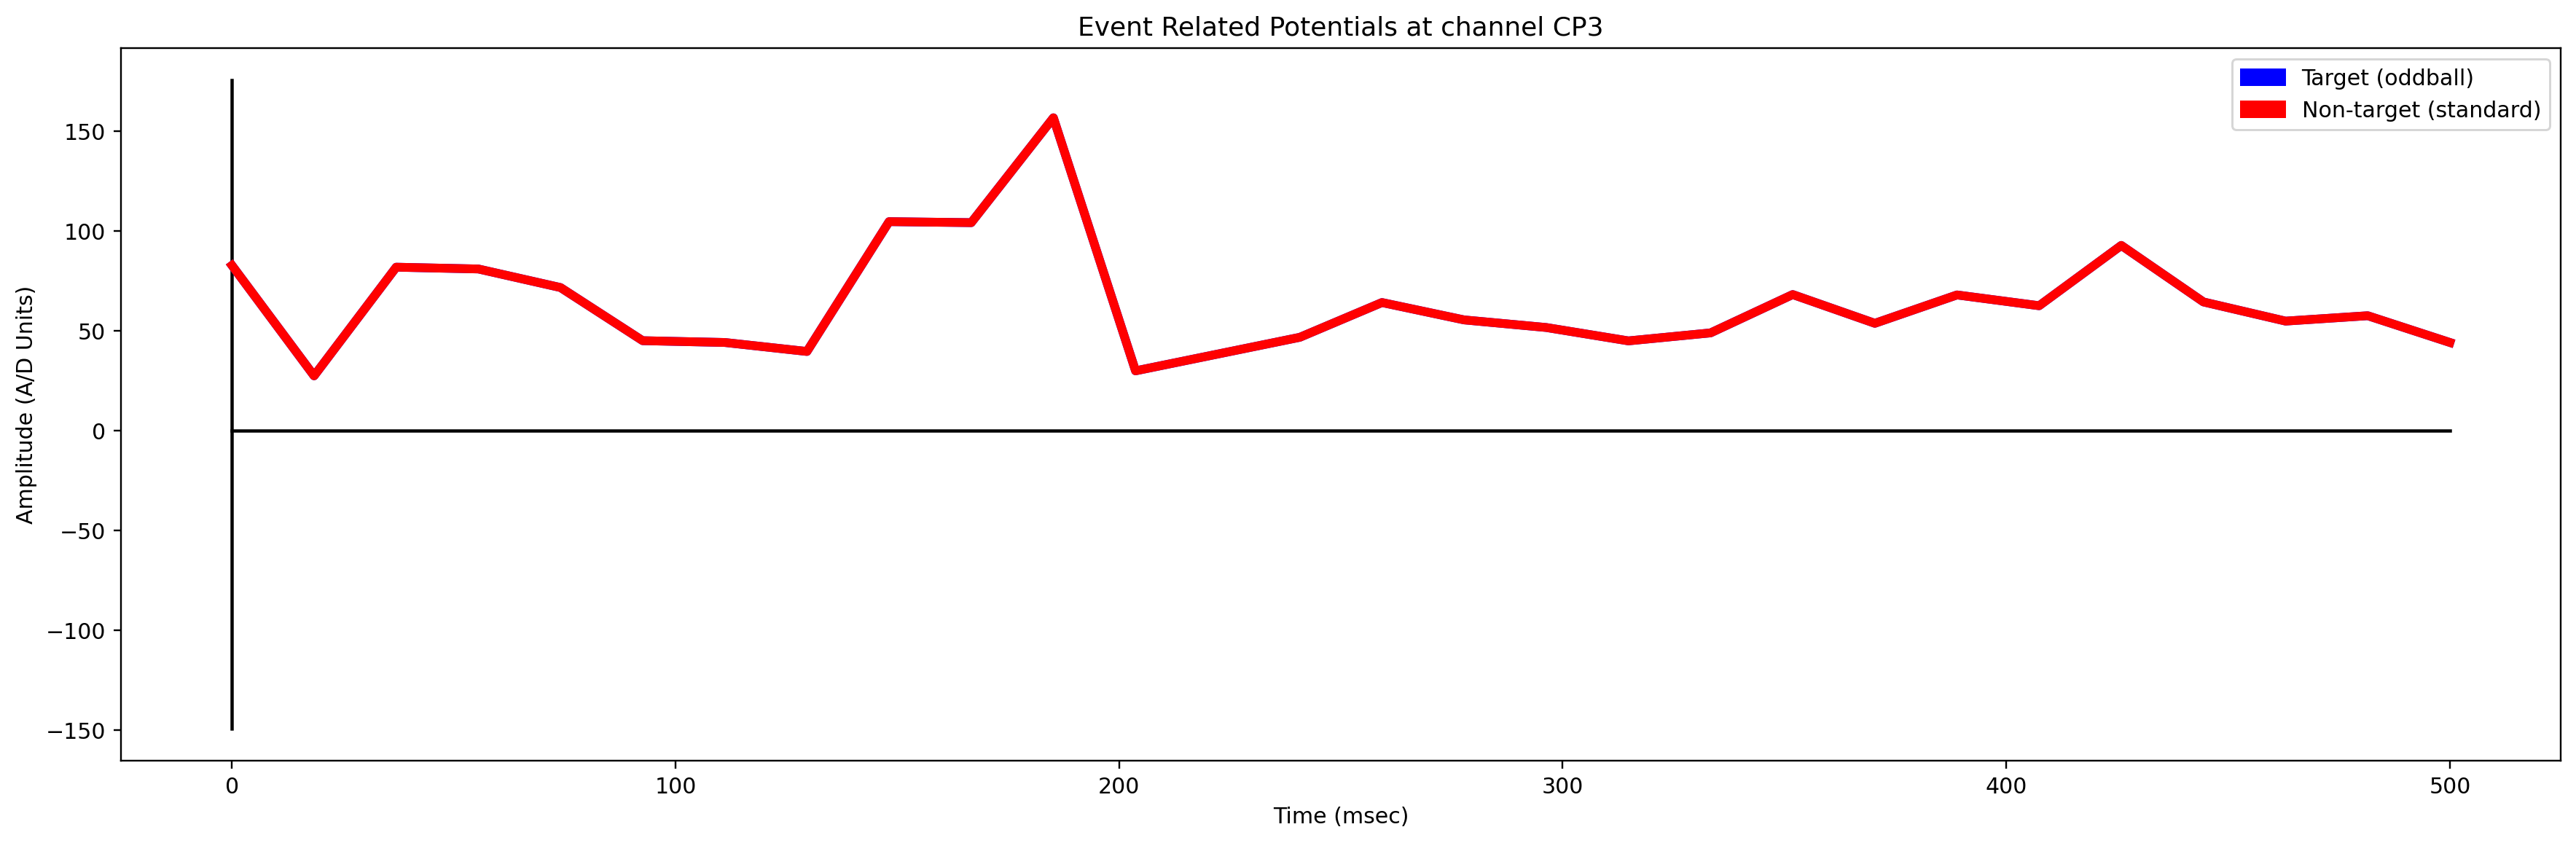

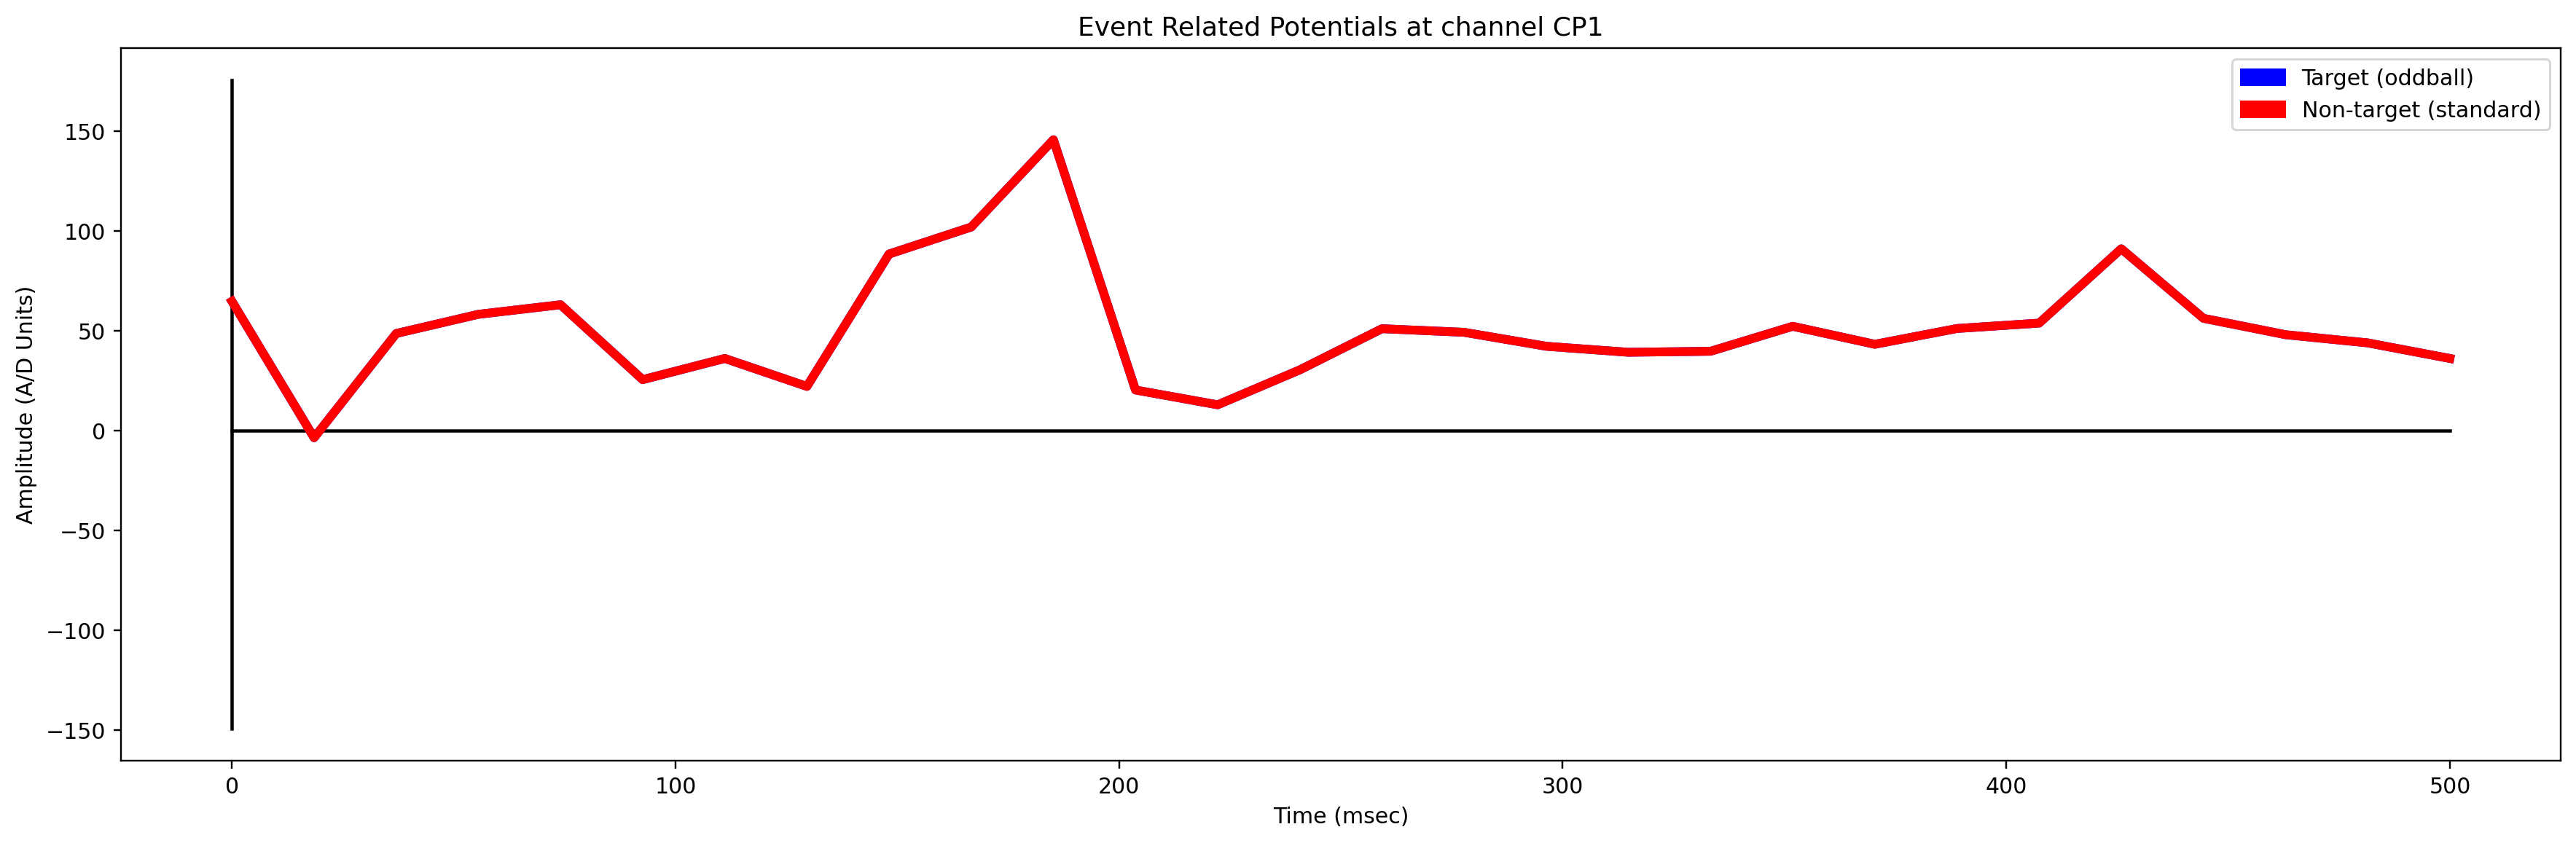

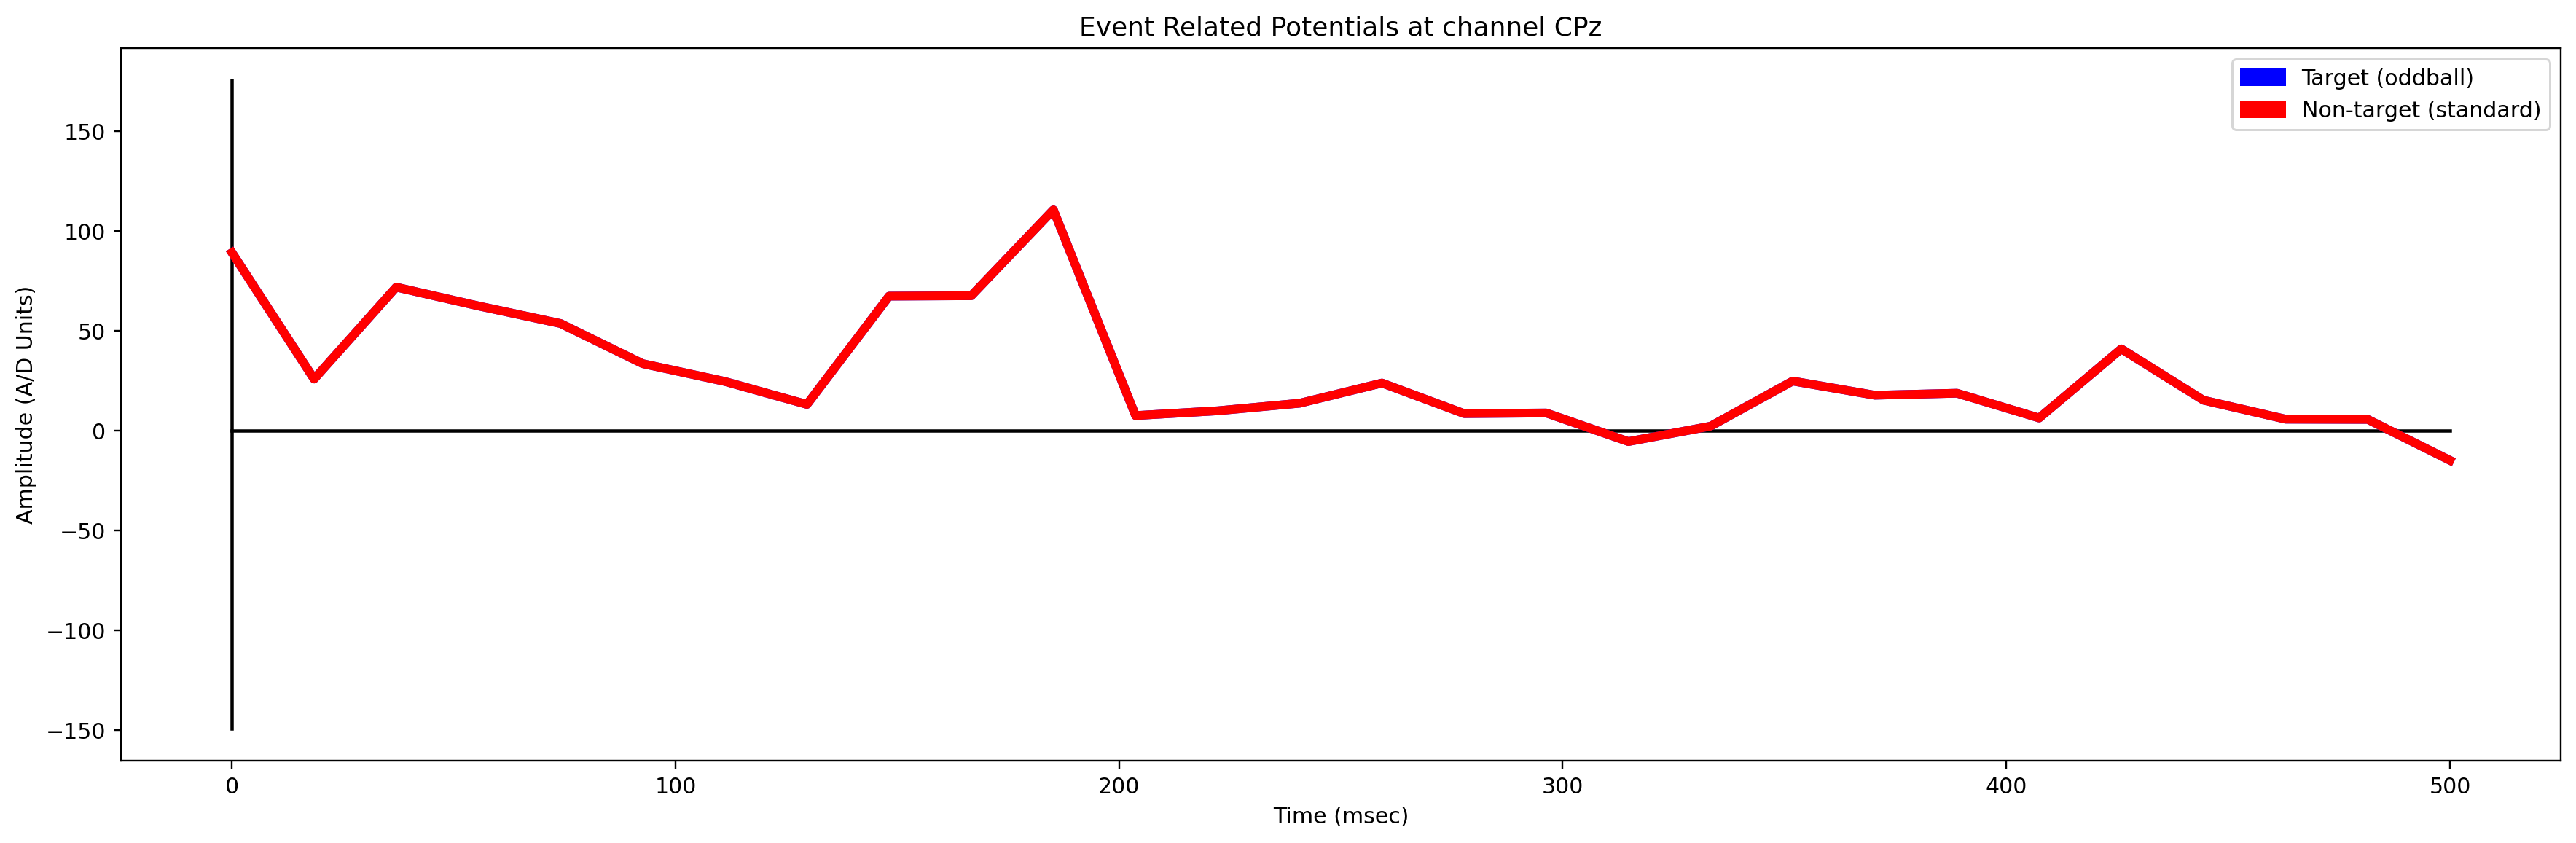

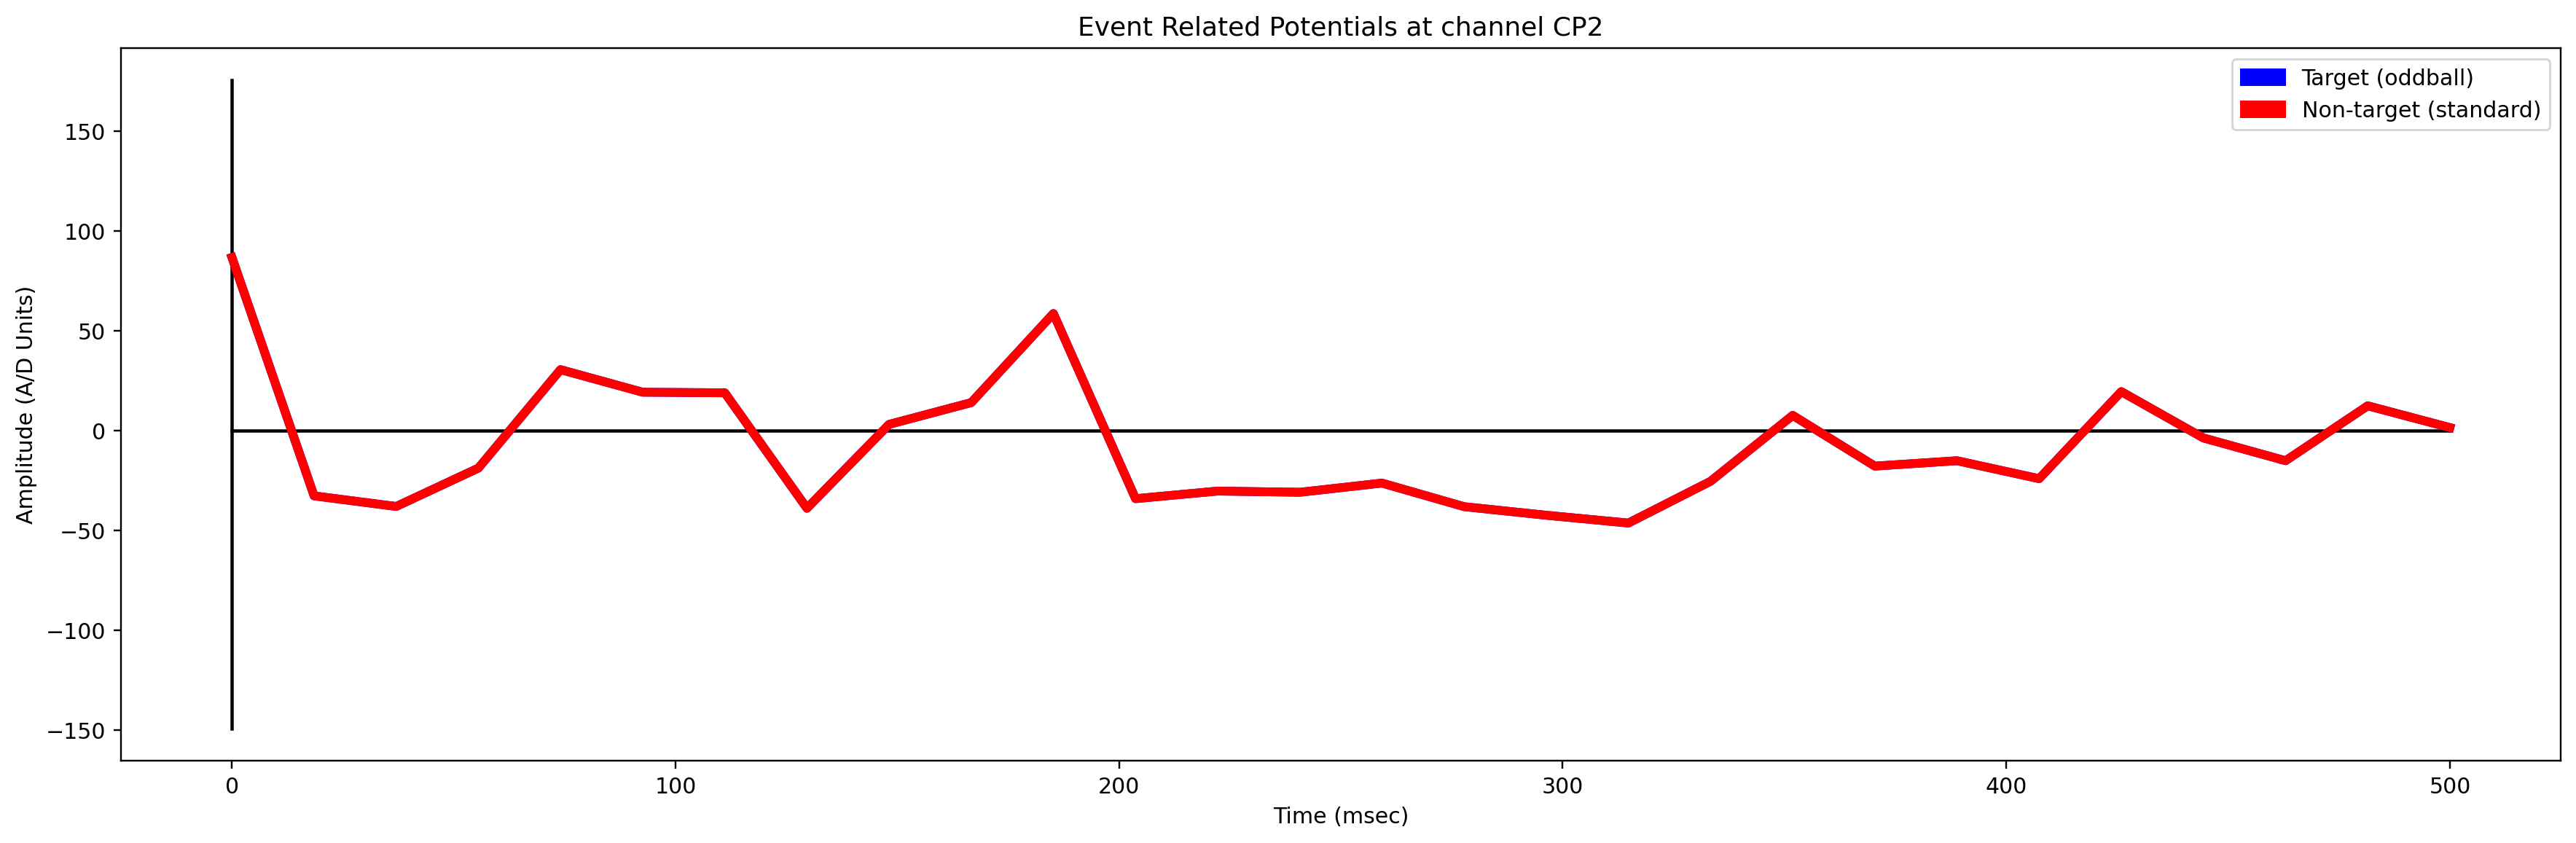

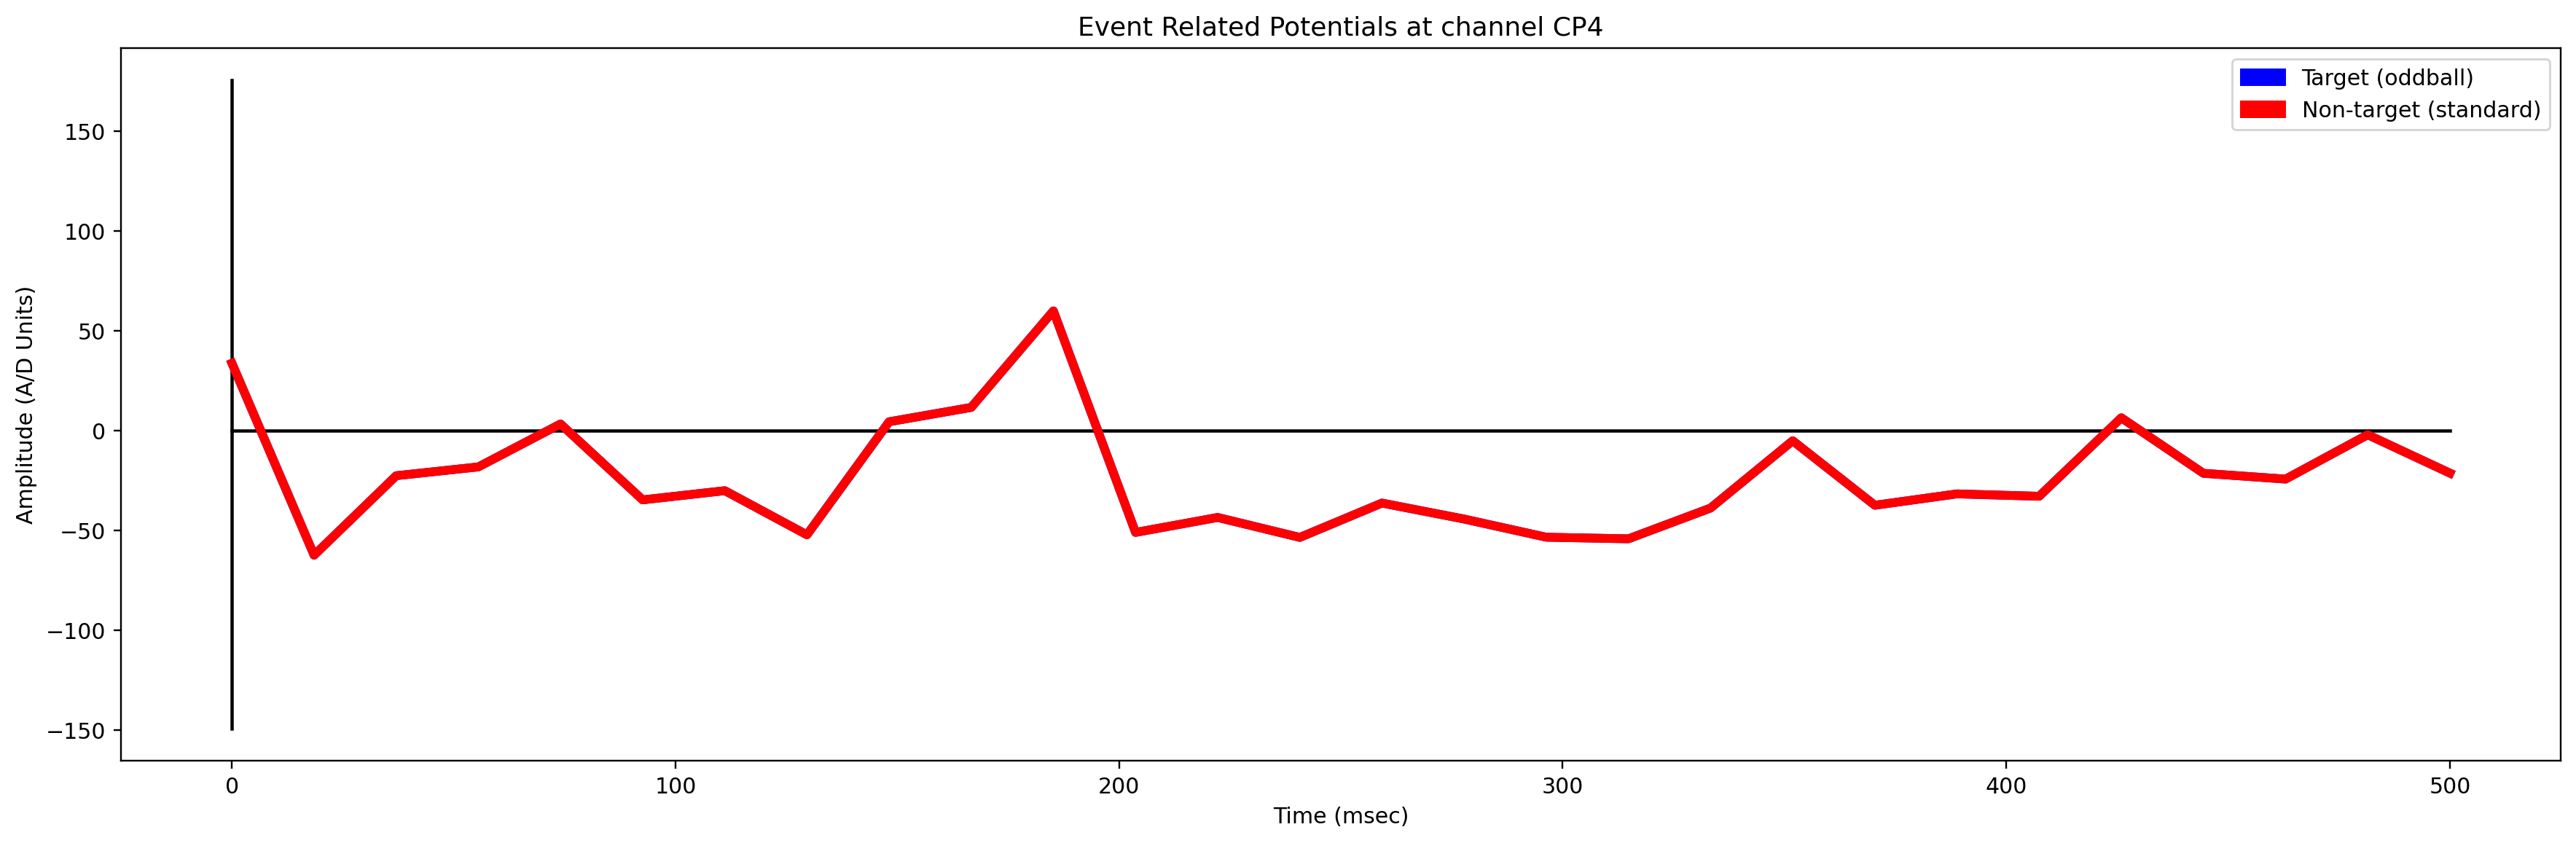

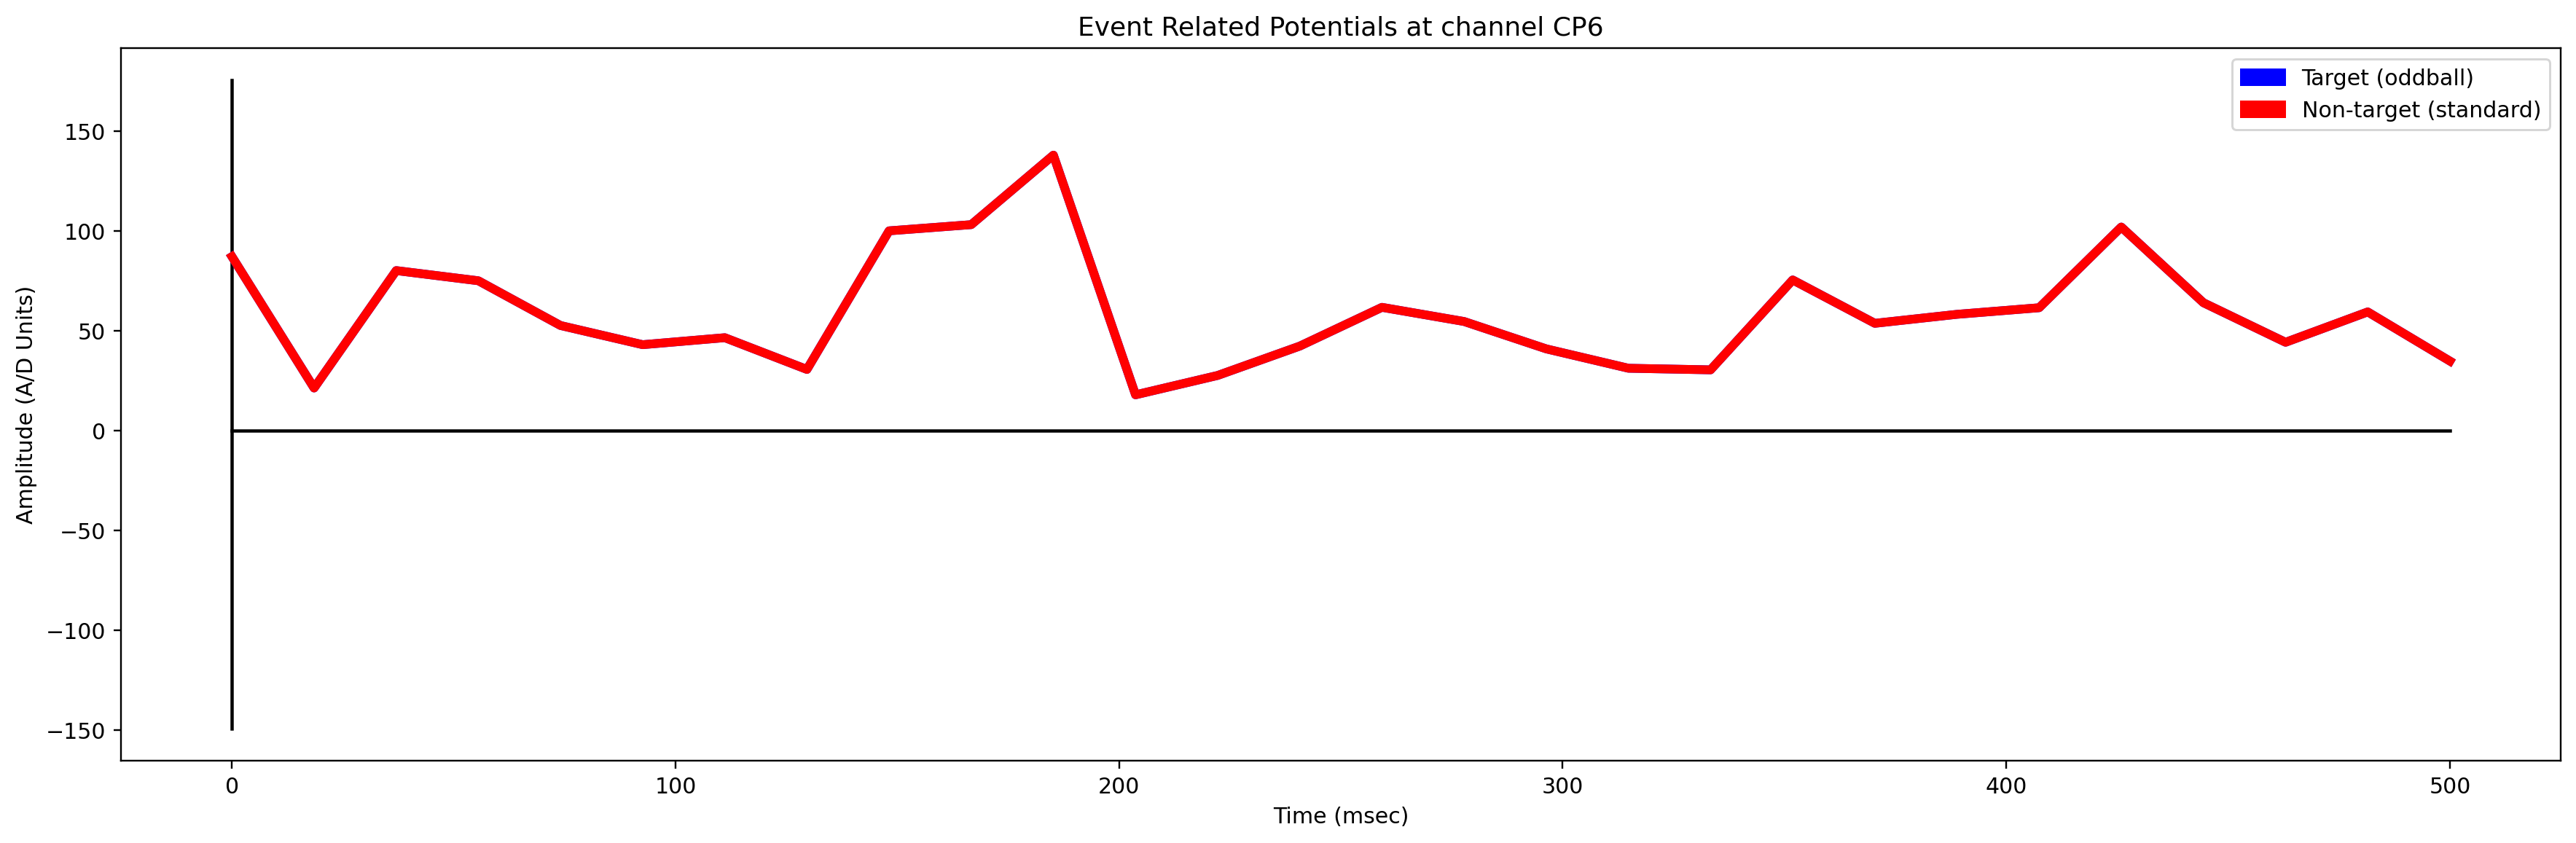

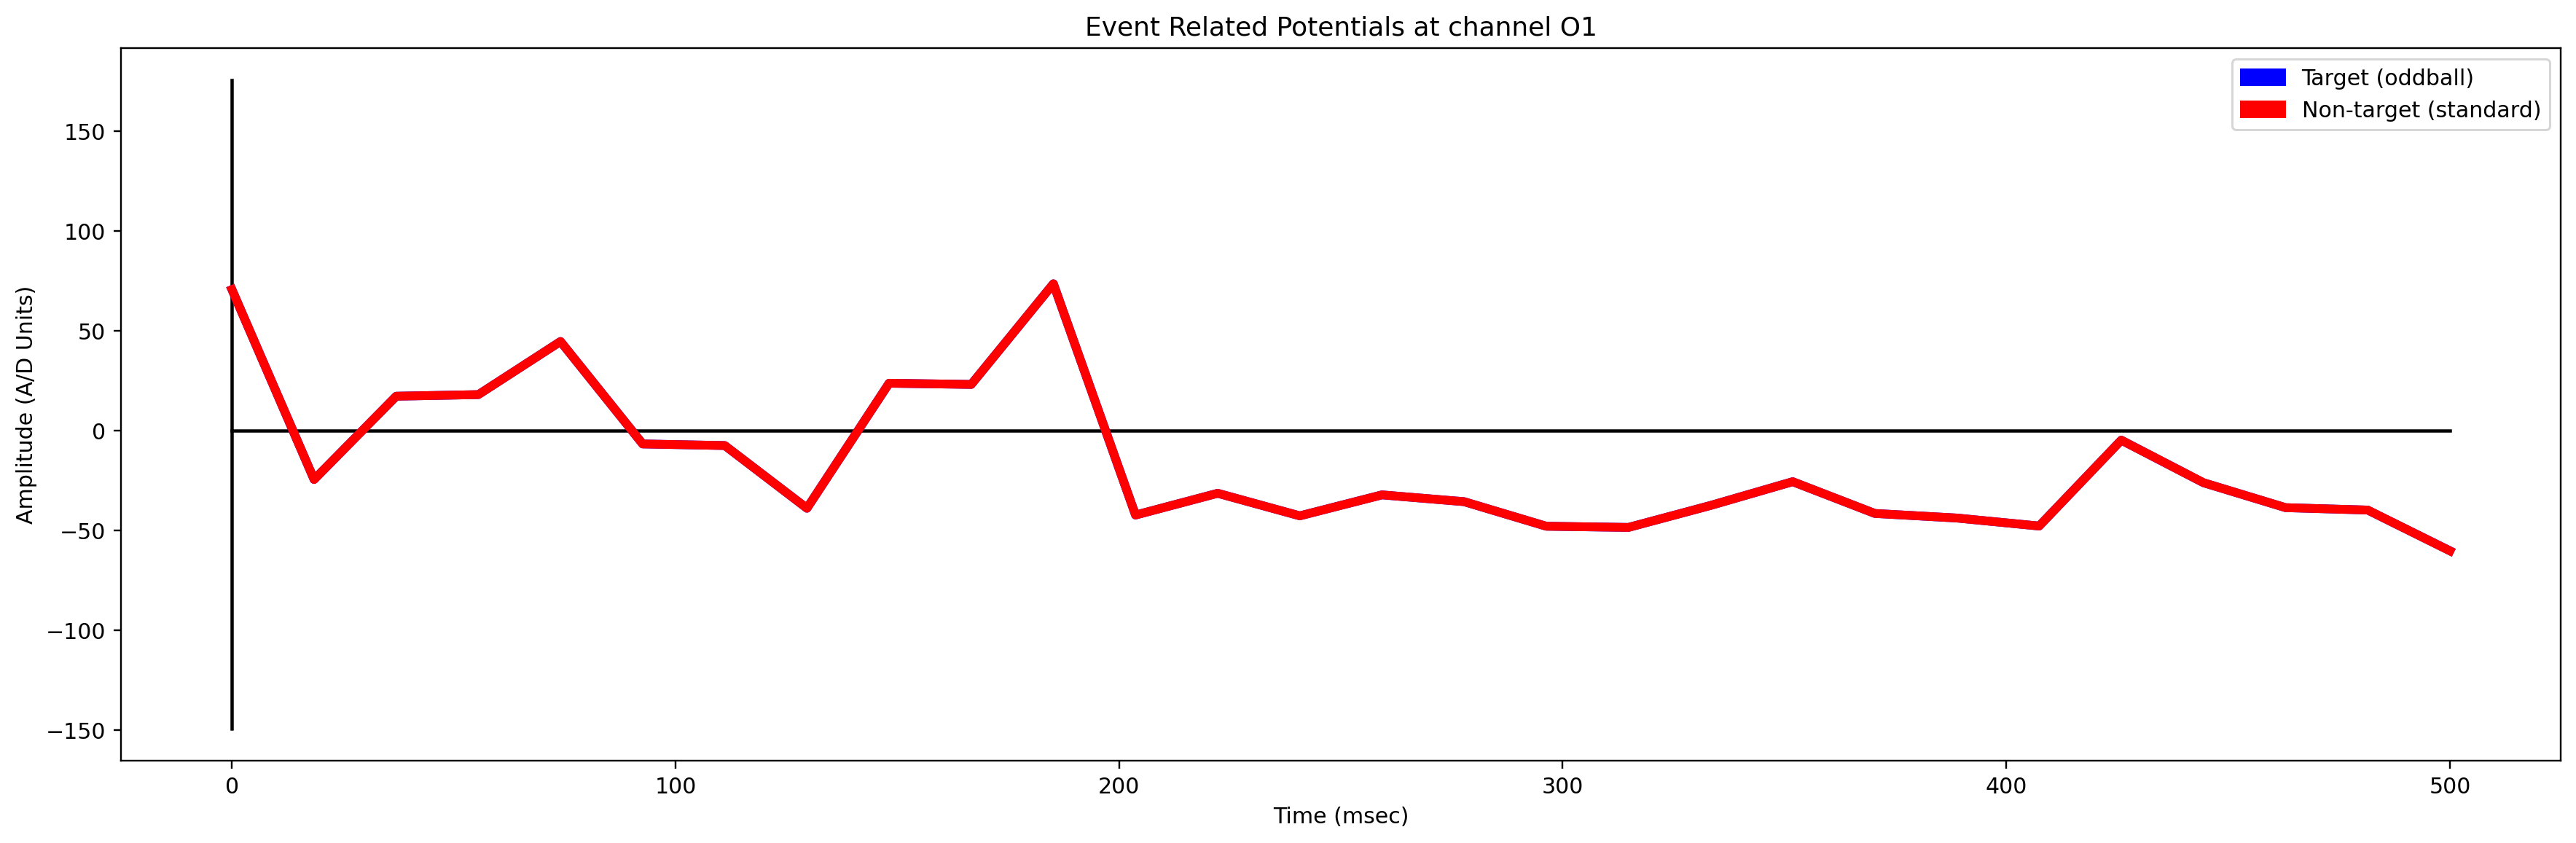

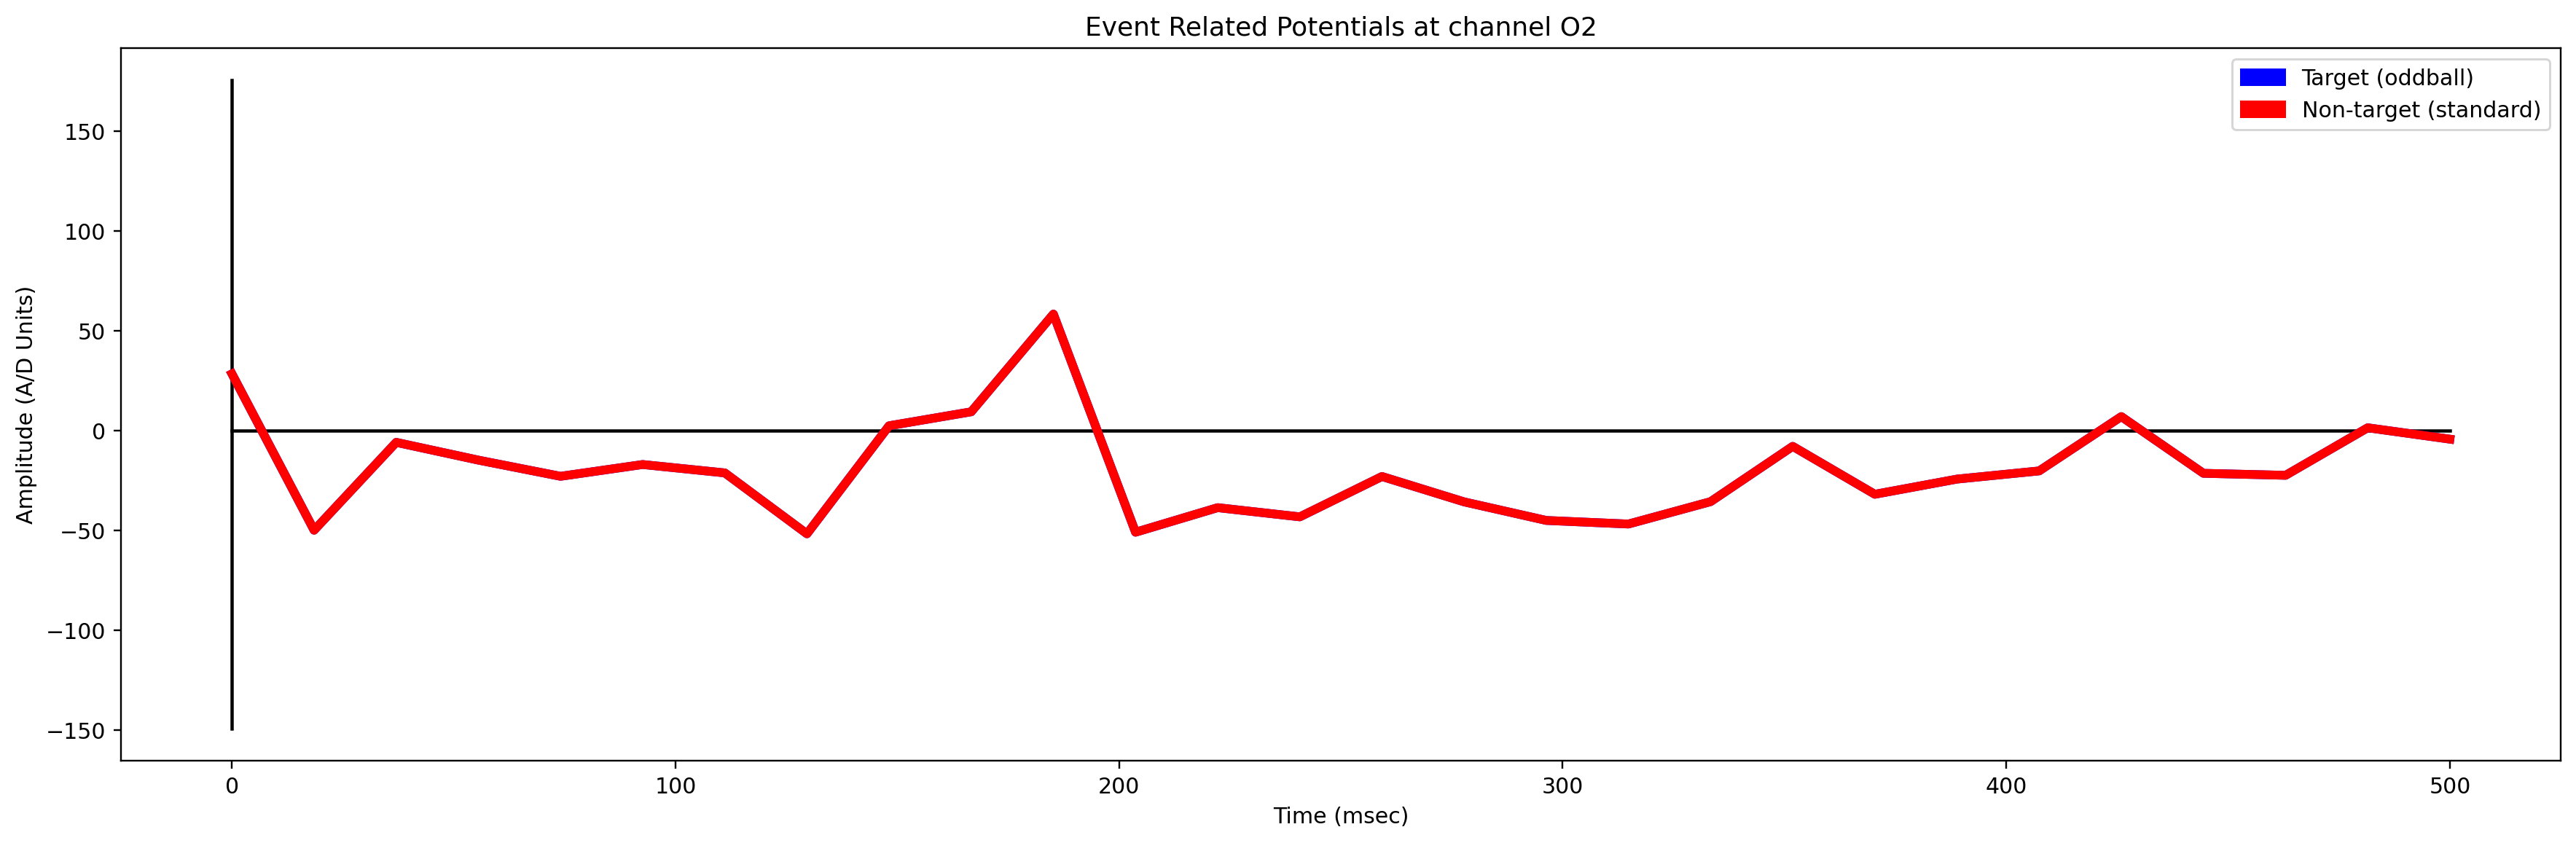

In [15]:
for chan in channels:
    # Define channel of interest and create an array of time points
#     chan = 'FC1' # let's plot Pz
    ch = np.where(clab_100 == chan)[1][0]
    times = np.linspace(epoch_start, epoch_end, x_train_100.shape[1])

    # Initialize plot and calculate min and max y value
    fig, ax = matplotlib.pyplot.subplots(nrows=1, ncols=1, figsize=(20, 6))
    min_y = min(np.min(tar_avg), np.min(non_tar_avg))
    max_y = max(np.max(tar_avg), np.max(non_tar_avg))

    # Plot x and y axes
    matplotlib.pyplot.plot([np.min(times), np.max(times)], [0, 0], color='k');  # x-axis
    matplotlib.pyplot.plot([0, 0], [min_y, max_y], color='k');                  # y-axis

    # Plot our averaged ERPs
    matplotlib.pyplot.plot(times, tar_avg[:, ch], 'b', linewidth=4)
    matplotlib.pyplot.plot(times, non_tar_avg[:, ch], 'r', linewidth=4)

#     #Highlight the baseline window and window of interest of our ERP
#     baseline = matplotlib.patches.Rectangle([baseline_start, min_y], baseline_end, np.abs(min_y)+max_y, 
#                                  color='cyan', alpha=0.2)
#     erp_win = matplotlib.patches.Rectangle([erp_start, min_y], erp_end-erp_start, np.abs(min_y)+max_y, 
#                                  color='lime', alpha=0.3)

#     # Add our baseline and window of interest highlights
#     ax.add_patch(baseline)
#     ax.add_patch(erp_win)

    # Manually create legends since patches will corrupt default handles
    legend_ = [matplotlib.patches.Patch(color='b', label = 'Target (oddball)'),
               matplotlib.patches.Patch(color='r', label = 'Non-target (standard)')]

    # Finalize plot and set a high DPI for a crisp, hi-res figure
    matplotlib.pyplot.xlabel('Time (msec)');
    matplotlib.pyplot.ylabel('Amplitude (A/D Units)');
    matplotlib.pyplot.legend(handles=legend_, loc="upper right");
    matplotlib.pyplot.title('Event Related Potentials at channel %s' % chan);
    fig.set_dpi(216);
    matplotlib.pyplot.show();

## Is this normal?

In [ ]:
# Plot our averaged ERPs
matplotlib.pyplot.plot(times, tar_avg[:, ch], 'b', linewidth=4)

In [ ]:
matplotlib.pyplot.plot(times, non_tar_avg[:, ch], 'r', linewidth=4)

In [ ]:
# Let's compute the windowed means within erp_start and erp_end
num_points = 5; # we will divide our window into num_points means

# Define a simple windowed means function
def wm(x, start, end, num_points):
    num_trials = x.shape[0] # assumes first dem is numb observations
    w = np.round((start+end)/num_points).astype(int)
    y = np.zeros((num_points, x.shape[-1], num_trials)) # assumes num chans as last dimension
    for i in range(0, num_points):
        s = start + (w * i)
        e = end   + (w * i)
        y[i, :, :] = np.mean(x[:, s:e, :], 1).T
    return y

# Combine into a single train variable. Also create labels
X_train    = wm(x_train_100, erp_s, erp_e, num_points)
markers_train = np.vstack((y_train_100, train_markers)).T
y = train_labels

# Now let's compute windowed means of our test data
X_test = wm(test_data, erp_s, erp_e, num_points)
markers_test = test_markers

# Let's print out the shapes of our data
print('X_train shape is: ' + str(X_train.shape))
print('y shape is......: ' + str(y.shape))
print('X_test shape is.: ' + str(X_test.shape))

Learn about the shape and length of the data

"fMRI has also been coupled with scalp electroencephalography (EEG) to estimate current sources associated with finger movements, which were found not only in the central sulcus, but also in frontal **medial and parietal regions** " 

In [ ]:
#Experimneting 
data_items = raw1.items()
data_list = list(data_items)
df = pd.DataFrame(data_list)

In [ ]:
#raw2 data which is recorded at 1000 Hz
data_1000 = list(raw2.items())
an_array = np.array(data, dtype = object)

temp3 = an_array[3]
clab_1000 = temp3[1]

temp4 = an_array[4]
x_train_1000 = temp4[1]

temp5 = an_array[5]
y_train_list = temp5[1]
y_train_1000 = y_train_list[0]

temp6 = an_array[6]
x_test_1000 = temp6[1]

print(len(x_train_1000))

In [8]:
clab_channels = clab_100[0]

In [9]:
channels = []

for j in clab_channels:
    
    for i in j:
        channels.append(i)
        
print(channels)

['F3', 'F1', 'Fz', 'F2', 'F4', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'O1', 'O2']


In [16]:
# Train our classifier (this may take a while via JupyterHub)
# clf_lsqrs = LinearDiscriminantAnalysis(solver = 'lsqr',  shrinkage = 'auto').fit(x_train, y)